# 공공 데이터 활용 온도 추정 경진대회 3등 코드 리뷰 + 개인 추가
- https://dacon.io/competitions/official/235584/codeshare/1045?page=1&dtype=recent&ptype=pub 
## 1. 배경

- 우리나라에는 전국에 걸쳐 시도별 기상관측소가 있어 지역별 기온을 알 수 있습니다. 각 지역 내에서도 대상과 위치에 따라 온도 차이가 많이 납니다. 여름날 뜨거운 아스팔트 위를 걸어보셨거나, 겨울철 칼바람 부는 교량위를 걸어보신 분들은 체감하셨을 겁니다. 그렇다고 '모든 곳'에 관측소를 만들어 '지속적'으로 측정하기는 어렵습니다.

- 그래서 생각해 낸 방법이 ‘기상청 공공데이터를 활용한 온도추정’ 입니다. 저가의 센서로 관심대상의 온도를 단기간 측정하여 기상청의 관측 데이터와의 상관관계 모델을 만들고, 이후엔 생성된 모델을 통해 온도를 추정하여 서비스하는 것입니다. 2013년 10월부터 시행된 ‘공공데이터의 제공 및 이용에 관한 법률 제 21조’ 에 의해 기상청에서 데이터를 무료로 제공하고 있습니다. 멋지지 않나요? 새로운 알고리즘을 통해 'MY 기상청'을 만들어주세요.

## 데이터 설명
-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다.
-     센서는 온도를 측정하였습니다.
-     **모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터** 입니다.
-     **예측 대상(target variable)은 Y18**입니다.

### train.csv 
- **30일 간의 기상청 데이터 (X00-X39) 및 센서데이터 (Y00-Y17)**
- 이후 **3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)**
- 센서데이터 - 실내외 19곳

- 30일간은 Y0 ~ Y17 측정 O / Y18 - 측정X
- 30일 지난 3일간은 Y0 ~ Y17 측정 X / Y18 - 측정 O
- Y18은 정말 정확하게 측정하기가 힘들 것임. (3일 밖에 없으니까)
### test.csv 
-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)

### 추가 데이터 설명
- https://dacon.io/competitions/official/235584/codeshare/737?page=1&dtype=recent&ptype=pub // 추가설명 잘나와있음.

- Dacon 답변 중 : 말씀하신 것처럼 5개의 변수는 각각 5개 지역의 기상청 관측 데이터를 의미합니다. 
- A지역: X00 / B지역: X07 / C지역: X28 / D지역: X31 / E지역: X32
- temperature_name = ["X00","X07","X28","X31","X32"] #기온
- localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
- speed_name       = ["X02","X03","X18","X24","X26"] #풍속
- water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
- press_name       = ["X05","X08","X09","X23","X33"] #해면기압
- sun_name         = ["X11","X14","X16","X19","X34"] #일일 누적일사량
- humidity_name    = ["X12","X20","X30","X37","X38"] #습도
- direction_name   = ["X13","X15","X17","X25","X35"] #풍향

### 시간
- 1일 = 24시간 = 1440분 = 144 행
- 3일 = 72시간 = 4320분 = 432 행
- 30일 = 720시간 = 43200분 = 4320 행
- train = 33일 = 792시간 = 47520분 = 4752 행 

In [210]:
# 기본
import sys, warnings
import re
import os
import datetime

# 시각화

import matplotlib.pyplot as plt
from matplotlib import rc 
import seaborn as sns
from IPython.display import display

# 데이터 처리

import pandas as pd
import numpy as np

# 머신러닝
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from xgboost import plot_importance

import pickle

# 수학
from scipy.stats.mstats import gmean
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import random

# 딥러닝
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, ReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import CustomObjectScope

print('tf Version \n', tf.__version__)
print('tf.keras Version \n', tf.keras.__version__)

rc('font', family='malgun gothic')
rc('axes', unicode_minus = False)

pd.set_option('display.max_columns', 1200)
np.set_printoptions(threshold = sys.maxsize)

warnings.filterwarnings("ignore")

%matplotlib inline
print('라이브러리 로드 완료')

tf Version 
 1.15.0
tf.keras Version 
 2.2.4-tf
라이브러리 로드 완료


In [211]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('데이터 로딩완료')

데이터 로딩완료


In [212]:
print(train.shape)
train

(4752, 60)


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.00,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.00,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.00,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.00,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.00,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,2.5,23.88,95.3,333.1,0.0,274.9,0.0,275.5,0.9,0.0,89.7,10.5,1000.4,1007.5,0.0,0.0,1.2,1006.0,23.8,999.4,89.9,17.7,19.1,1007.5,22.16,218.6,0.0,82.3,58.6,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,2.5,23.88,95.6,216.4,0.0,277.3,0.0,247.0,1.0,0.0,90.1,10.5,1000.3,1007.5,0.0,0.0,1.3,1006.0,23.6,999.4,91.3,17.7,19.2,1007.5,22.16,161.7,0.0,82.5,59.1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,2.5,23.88,95.9,127.8,0.0,256.1,0.0,299.1,0.6,0.0,90.8,10.5,1000.4,1007.6,0.0,0.0,0.2,1006.0,23.6,999.5,90.2,17.8,19.2,1007.5,22.16,254.2,0.0,83.0,58.9,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4750,4750,19.4,987.7,0.9,0.8,0.0,1006.9,987.8,21.3,1007.6,1007.5,2.5,23.88,95.9,323.8,0.0,255.1,0.0,0.0,0.6,0.0,91.5,10.5,1000.4,1007.6,0.0,0.0,0.1,1006.0,23.3,999.5,90.1,17.7,19.3,1007.6,22.16,300.0,0.0,83.2,59.8,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [213]:
print(test.shape)
test

(11520, 41)


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,4752,18.7,987.4,1.5,1.3,0.0,1006.8,987.7,21.1,1007.5,1007.2,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,1007.6,0.0,0.0,0.1,1006.0,23.2,999.5,91.4,17.5,19.2,1007.6,0.00,194.7,0.0,84.0,59.9,0.0
1,4753,18.8,987.4,1.1,1.2,0.0,1006.7,987.7,21.2,1007.5,1007.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,1007.5,0.0,0.0,0.3,1005.9,23.1,999.4,91.6,17.4,19.1,1007.5,0.00,173.1,0.0,84.0,60.5,0.0
2,4754,19.0,987.4,1.3,1.2,0.0,1006.6,987.6,21.2,1007.4,1007.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,1007.4,0.0,0.0,0.7,1005.9,23.1,999.3,92.0,17.2,19.0,1007.5,0.00,208.6,0.0,85.0,60.8,0.0
3,4755,18.7,987.4,2.3,0.8,0.0,1006.6,987.6,21.1,1007.4,1007.2,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,1007.4,0.0,0.0,0.6,1005.8,22.8,999.3,93.0,17.2,18.8,1007.4,0.00,185.0,0.0,85.8,61.2,0.0
4,4756,18.4,987.4,1.1,0.7,0.0,1006.7,987.7,20.9,1007.5,1007.2,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,1007.3,0.0,0.0,0.7,1005.9,22.8,999.2,92.3,17.4,18.9,1007.5,0.00,162.8,0.0,87.3,61.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,16267,25.7,993.2,3.9,3.8,0.0,1011.7,993.8,26.3,1013.3,1012.6,0.0,17.1,88.1,65.6,0.0,101.6,0.0,176.7,1.8,0.0,77.3,0.0,1005.2,1012.9,1.6,169.8,4.5,1011.5,27.7,1004.9,76.6,23.6,24.4,1013.0,19.56,169.6,0.0,79.7,67.5,0.5
11516,16268,25.6,993.2,3.0,3.0,0.0,1011.7,993.8,26.3,1013.3,1012.6,0.0,17.1,75.5,51.9,0.0,84.8,0.0,187.8,2.9,0.0,78.1,0.0,1005.2,1012.9,1.9,138.9,4.7,1011.4,27.6,1004.9,76.7,25.3,24.4,1012.9,19.56,175.9,0.0,79.6,67.9,0.5
11517,16269,25.6,993.2,3.8,2.5,0.0,1011.9,993.7,26.2,1013.2,1012.7,0.0,17.1,77.5,29.0,0.0,104.5,0.0,184.8,2.9,0.0,78.9,0.0,1005.4,1013.0,2.3,146.7,4.8,1011.4,27.5,1005.0,77.1,24.9,24.3,1012.9,19.56,204.7,0.0,79.2,68.3,0.5
11518,16270,25.5,993.2,2.4,2.8,0.0,1011.8,993.7,26.1,1013.2,1012.6,0.0,17.1,74.1,30.0,0.0,103.0,0.0,187.8,3.4,0.0,79.7,0.0,1005.3,1013.0,1.7,146.5,3.5,1011.4,27.3,1005.0,77.3,25.3,24.2,1012.9,19.56,174.2,0.0,80.1,68.8,0.5


# 2. 데이터 전처리
## Data Cleansing & Pre-Processing

In [214]:
# column 들 정리

X_data = pd.concat([train, test], sort=False).iloc[:,:41].reset_index()
X_data = X_data.drop(columns=['index'],axis=1)

# train + test columns 이름 붙이기.
X_data.columns=['id','Temp_1','LocPr_1','WinSp_1','WinSp_2','Rain_1','SeaPr_1','LocPr_2','Temp_2','SeaPr_2','SeaPr_3','Rain_2','Insol_1',
                'Humid_1','WinDi_1','Insol_2','WinDi_2','Insol_3','WinDi_3','WinSp_3','Insol_4','Humid_2','Rain_3','LocPr_3','SeaPr_4',
                'WinSp_4','WinDi_4','WinSp_5','LocPr_4','Temp_3','LocPr_5','Humid_3','Temp_4','Temp_5','SeaPr_5','Insol_5','WinDi_5',
                'Rain_4','Humid_4','Humid_5','Rain_5']

X_data = X_data[['id','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5', 'LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5',
                 'SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5', 'WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5',
                 'WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5', 'Rain_1','Rain_2','Rain_3','Rain_4','Rain_5',
                 'Insol_1','Insol_2','Insol_3','Insol_4','Insol_5', 'Humid_1','Humid_2','Humid_3','Humid_4','Humid_5']]

# test_columns 이름 붙이기 (41열)
test.columns = ['id','Temp_1','LocPr_1','WinSp_1','WinSp_2','Rain_1','SeaPr_1','LocPr_2','Temp_2','SeaPr_2','SeaPr_3','Rain_2','Insol_1',
                'Humid_1','WinDi_1','Insol_2','WinDi_2','Insol_3','WinDi_3','WinSp_3','Insol_4','Humid_2','Rain_3','LocPr_3','SeaPr_4',
                'WinSp_4','WinDi_4','WinSp_5','LocPr_4','Temp_3','LocPr_5','Humid_3','Temp_4','Temp_5','SeaPr_5','Insol_5','WinDi_5',
                'Rain_4','Humid_4','Humid_5','Rain_5']

#test = test.drop(columns=['Insol_2','Insol_3','Insol_4'])
test = test[['id','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5',
   'LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5',
   'SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5',
   'WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5',
   'WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5',
   'Rain_1','Rain_2','Rain_3','Rain_4','Rain_5',
   'Insol_1','Insol_2','Insol_3','Insol_4','Insol_5',
  'Humid_1','Humid_2','Humid_3','Humid_4','Humid_5']]


train.columns = ['id','Temp_1','LocPr_1','WinSp_1','WinSp_2','Rain_1','SeaPr_1','LocPr_2','Temp_2','SeaPr_2','SeaPr_3','Rain_2','Insol_1'
                 ,'Humid_1','WinDi_1','Insol_2','WinDi_2','Insol_3','WinDi_3','WinSp_3','Insol_4','Humid_2','Rain_3','LocPr_3','SeaPr_4',
                 'WinSp_4','WinDi_4','WinSp_5','LocPr_4','Temp_3','LocPr_5','Humid_3','Temp_4','Temp_5','SeaPr_5','Insol_5','WinDi_5',
                 'Rain_4','Humid_4','Humid_5','Rain_5',
                 'Y00','Y01','Y02',"Y03",'Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']

#train = train.drop(columns=['Insol_2','Insol_3','Insol_4'])
train = train[['id','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5', 'LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5',
    'SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5', 'WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5',
    'WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5', 'Rain_1','Rain_2','Rain_3','Rain_4','Rain_5',
    'Insol_1','Insol_2','Insol_3','Insol_4','Insol_5', 'Humid_1','Humid_2','Humid_3','Humid_4','Humid_5',
    'Y00','Y01','Y02',"Y03",'Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']]

# 기온
Temperature = ['Temp_1','Temp_2','Temp_3','Temp_4','Temp_5']

# 지면기압
Localpressure = ['LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5']

# 풍속
Windspeed = ['WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5']

# 강수
Rain = ['Rain_1','Rain_2','Rain_3','Rain_4','Rain_5']

# 해면 기압
Seapressure = ['SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5']

# 일사량
Insolation = ['Insol_1','Insol_2','Insol_3','Insol_4','Insol_5']

# 습도
Humid = ['Humid_1','Humid_2','Humid_3','Humid_4','Humid_5']

# 바람의 방향
Winddirection = ['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5']

# 시간
Time = ['minute','hour','day']

# 센서 
Y_data =  ['Y00','Y01','Y02','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']

print('column들 선언 완료')

column들 선언 완료


# 3. 탐색적 자료분석
## Exploratory Data Analysis
### a) Y00-Y18의 상관관계
- 코드공유에 올라와 있는 InCastle님의 자료를 참고하였습니다.
- 출처 : https://dacon.io/competitions/official/235584/codeshare/707

- Y18이 null => Y0 ~ Y17은 not null
- Y0 ~ Y17이 null => Y18은 not null

In [215]:
## 1) Y18이 null => Y0 ~ Y17은 not null
temp = train[train['Y18'].isnull()]

# 값중에서 하나라도 null 이 있다면 True 반환
print(temp.shape)
print(temp.iloc[:, -19:-1].isnull().any()) # False

## 2) Y0 ~ Y17이 null => Y18은 not null
temp = train[~train['Y18'].isnull()]

# 값중에서 하나라도 null 이 있다면 True 반환
print(temp.shape)
print(temp.iloc[:,-19:-1].isnull().all())

(4320, 60)
Y00    False
Y01    False
Y02    False
Y03    False
Y04    False
Y05    False
Y06    False
Y07    False
Y08    False
Y09    False
Y10    False
Y11    False
Y12    False
Y13    False
Y14    False
Y15    False
Y16    False
Y17    False
dtype: bool
(432, 60)
Y00    True
Y01    True
Y02    True
Y03    True
Y04    True
Y05    True
Y06    True
Y07    True
Y08    True
Y09    True
Y10    True
Y11    True
Y12    True
Y13    True
Y14    True
Y15    True
Y16    True
Y17    True
dtype: bool


### test 데이터에서 우리가 실제로 예측해야하는 값은 Y00~Y17이 아닌 Y18입니다.
- 이에 우리는 Y00~Y17만 있는 row는 Y18과 유사한 값을 가진 새로운 target attribute를 만들어줘야 합니다.
- 이를 위해 Y00~Y17 vs Y18 사이에 관계를 살펴보겠습니다.

In [216]:
train[~train['Y18'].isnull()]['Y18']

4320    20.5
4321    20.5
4322    20.5
4323    20.5
4324    20.5
        ... 
4747    21.5
4748    21.5
4749    21.5
4750    21.5
4751    21.0
Name: Y18, Length: 432, dtype: float64

In [217]:
y18 = train[~train['Y18'].isnull()]['Y18'].reset_index(drop= True)
y18

0      20.5
1      20.5
2      20.5
3      20.5
4      20.5
       ... 
427    21.5
428    21.5
429    21.5
430    21.5
431    21.0
Name: Y18, Length: 432, dtype: float64

In [218]:
no_y18_target = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08','Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']
no_y18 = train[(train['Y18'].isnull())][no_y18_target].reset_index(drop = True)
no_y18

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0
1,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0
2,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5
3,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5
4,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0
4316,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5
4317,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0
4318,21.5,22.0,22.0,25.5,25.5,20.5,20.0,20.0,20.0,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0


In [219]:
check_target = pd.concat([no_y18, y18], axis = 1)
check_target

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,20.5
1,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,20.5
2,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,20.5
3,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,20.5
4,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0,NaN
4316,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5,NaN
4317,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0,NaN
4318,21.5,22.0,22.0,25.5,25.5,20.5,20.0,20.0,20.0,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0,NaN


Text(0.5, 1, 'Correlation Heatmap')

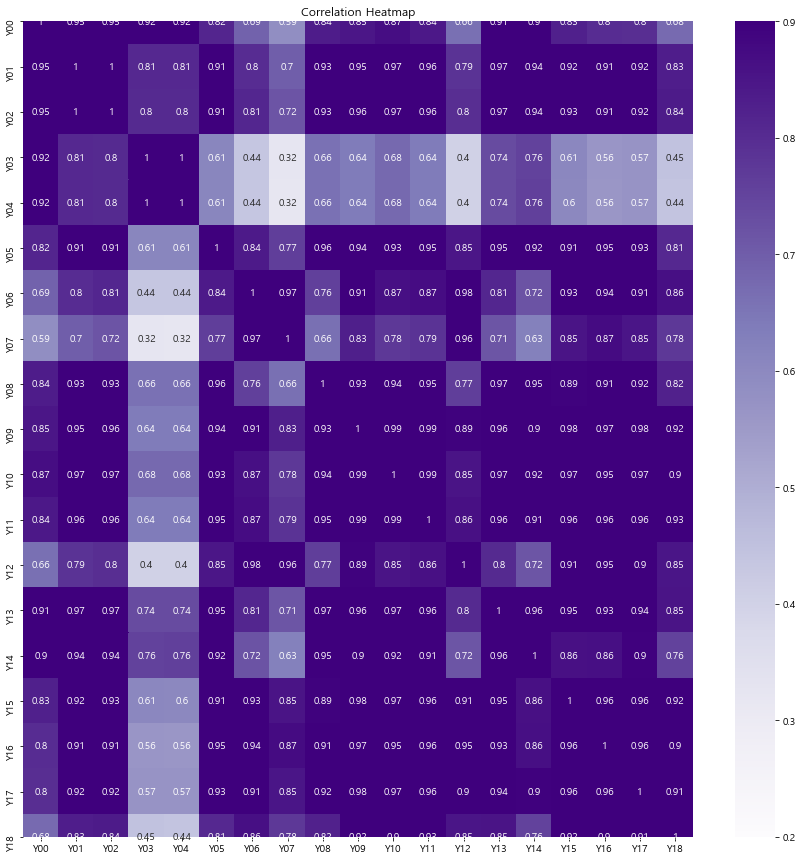

In [220]:
correlations =  check_target.corr()
plt.figure(figsize = (15, 15))

# Heatmap of correlations
sns.heatmap(correlations, cmap = 'Purples',  vmin = 0.2, annot = True, vmax = 0.9)
plt.title('Correlation Heatmap')

In [221]:
# => y18과 여타 변수들의 관계를 살펴봤음. y0 ~ y17

In [222]:
# * 효율적인 EDA를 위해 Time 피쳐 추가
# time 피쳐들 ? 왜 넣은거지? 시계열적으로 바라볼려고??

# 1일 = 24시간 = 1440분 = 144 행 
# 3일 = 72시간 = 4320분 = 432 행 
# 30일 = 720시간 = 43200분 = 4320 행 
# train = 33일 = 792시간 = 47520분 = 4752 행 ==> 합이 33일이니까.

time = pd.DataFrame(train.id.apply(lambda x:x%144)) # id 144 이하 정수로
time.columns = ['minute'] # 
time['hour'] = time.minute.apply(lambda x:x//6+1)
time['day'] = time.index // 144+1

time

,minute,hour,day
0,0,1,1
1,1,1,1
2,2,1,1
3,3,1,1
4,4,1,1
...,...,...,...
4747,139,24,33
4748,140,24,33
4749,141,24,33
4750,142,24,33


In [223]:
# train - time ==> concat
train = pd.concat([train, time], axis =1) # 가로로 합침
train

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_2,Insol_3,Insol_4,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,minute,hour,day
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,82.4,91.0,69.1,77.2,62.6,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN,0,1,1
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,81.2,91.9,70.3,77.3,63.5,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN,1,1,1
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,86.1,93.3,71.5,77.3,63.9,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN,2,1,1
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,87.7,93.4,73.2,77.5,64.5,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN,3,1,1
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,88.9,94.1,74.3,78.0,65.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,4747,19.9,21.7,23.8,17.7,19.1,987.6,987.7,1000.4,1006.0,999.4,1006.9,1007.5,1007.4,1007.5,1007.5,0.9,0.8,0.9,0.0,1.2,333.1,274.9,275.5,0.0,218.6,0.0,2.5,10.5,0.0,0.5,23.88,0.0,0.0,0.0,22.16,95.3,89.7,89.9,82.3,58.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,139,24,33
4748,4748,19.9,21.6,23.6,17.7,19.2,987.6,987.7,1000.3,1006.0,999.4,1006.8,1007.5,1007.4,1007.5,1007.5,0.5,0.7,1.0,0.0,1.3,216.4,277.3,247.0,0.0,161.7,0.0,2.5,10.5,0.0,0.5,23.88,0.0,0.0,0.0,22.16,95.6,90.1,91.3,82.5,59.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,140,24,33
4749,4749,19.7,21.4,23.6,17.8,19.2,987.7,987.6,1000.4,1006.0,999.5,1006.9,1007.4,1007.5,1007.6,1007.5,0.9,0.6,0.6,0.0,0.2,127.8,256.1,299.1,0.0,254.2,0.0,2.5,10.5,0.0,0.5,23.88,0.0,0.0,0.0,22.16,95.9,90.8,90.2,83.0,58.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,141,24,33
4750,4750,19.4,21.3,23.3,17.7,19.3,987.7,987.8,1000.4,1006.0,999.5,1006.9,1007.6,1007.5,1007.6,1007.6,0.9,0.8,0.6,0.0,0.1,323.8,255.1,0.0,0.0,300.0,0.0,2.5,10.5,0.0,0.5,23.88,0.0,0.0,0.0,22.16,95.9,91.5,90.1,83.2,59.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,142,24,33


In [224]:
# day 33개 별로 groupby 및 값 merge
a = train.groupby('day')['Temp_1'].agg([('평균온도_1', 'mean')]).reset_index()
b = train.groupby('day')['Temp_2'].agg([('평균온도_2', 'mean')]).reset_index()
c = train.groupby('day')['Temp_3'].agg([('평균온도_3', 'mean')]).reset_index()
d = train.groupby('day')['Temp_4'].agg([('평균온도_4', 'mean')]).reset_index()
e = train.groupby('day')['Temp_5'].agg([('평균온도_5', 'mean')]).reset_index()
a

,day,평균온도_1
0,1,15.938194
1,2,18.106944
2,3,20.927083
3,4,21.520139
4,5,21.058333
5,6,22.952778
6,7,17.432639
7,8,16.727778
8,9,18.281944
9,10,18.550694


In [225]:
# 훈련데이터가 33일치니까.
# day 33개 별로 groupby 및 값 merge
temp_day = pd.merge(a,b, left_on = 'day', right_on = 'day', how = 'left')
temp_day = pd.merge(temp_day,c, left_on = 'day', right_on = 'day', how = 'left')
temp_day = pd.merge(temp_day,d, left_on = 'day', right_on = 'day', how = 'left')
temp_day = pd.merge(temp_day,e, left_on = 'day', right_on = 'day', how = 'left')

temp_day

,day,평균온도_1,평균온도_2,평균온도_3,평균온도_4,평균온도_5
0,1,15.938194,17.679861,17.801389,14.962500,15.740972
1,2,18.106944,20.536111,20.692361,17.138889,18.697917
2,3,20.927083,22.909722,23.191667,19.010417,19.846528
3,4,21.520139,24.206250,25.123611,21.811806,22.053472
4,5,21.058333,23.980556,24.436806,21.906944,21.707639
5,6,22.952778,24.549306,25.417361,21.931944,22.523611
6,7,17.432639,18.522917,18.924306,17.671528,17.654167
7,8,16.727778,17.509722,18.832639,16.318750,15.809722
8,9,18.281944,20.079167,20.783333,17.490972,17.583333
9,10,18.550694,20.260417,20.529167,17.913194,17.903472


### b) 일별 온도 흐름

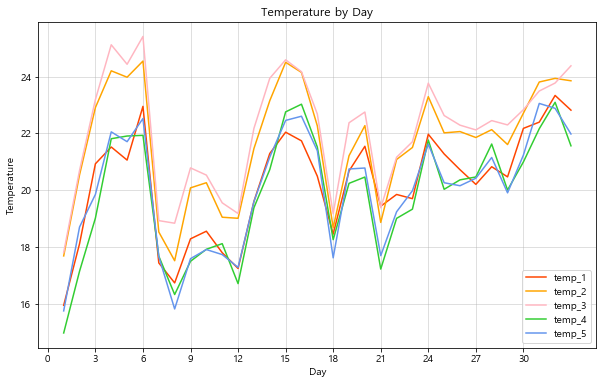

In [226]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

colors = ['orangered','orange','lightpink','limegreen','cornflowerblue']

# temp_day와 day를 그래프로 그려봄.
plt.plot(temp_day.day, temp_day.평균온도_1, color = 'orangered', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_2, color = 'orange', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_3, color = 'lightpink', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_4, color = 'limegreen',linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Temperature')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['temp_1','temp_2','temp_3','temp_4','temp_5',])

plt.title('Temperature by Day')

plt.show()

### c) 시간별 온도 흐름

In [227]:
# hour 24개 별로 groupby 및 값 merge

a = train.groupby('hour')['Temp_1'].agg([('평균온도_1', 'mean')]).reset_index()
b = train.groupby('hour')['Temp_2'].agg([('평균온도_2', 'mean')]).reset_index()
c = train.groupby('hour')['Temp_3'].agg([('평균온도_3', 'mean')]).reset_index()
d = train.groupby('hour')['Temp_4'].agg([('평균온도_4', 'mean')]).reset_index()
e = train.groupby('hour')['Temp_5'].agg([('평균온도_5', 'mean')]).reset_index()

a

,hour,평균온도_1
0,1,16.494949
1,2,16.069192
2,3,15.689394
3,4,15.294949
4,5,14.959091
5,6,14.867677
6,7,15.588384
7,8,17.046465
8,9,18.995455
9,10,20.947475


In [228]:
# hour 24개 별로 groupby 및 값 merge

temp_hour = pd.merge(a,b, left_on = 'hour', right_on = 'hour', how = 'left')
temp_hour = pd.merge(temp_hour,c, left_on = 'hour', right_on = 'hour', how = 'left')
temp_hour = pd.merge(temp_hour,d, left_on = 'hour', right_on = 'hour', how = 'left')
temp_hour = pd.merge(temp_hour,e, left_on = 'hour', right_on = 'hour', how = 'left')
temp_hour

,hour,평균온도_1,평균온도_2,평균온도_3,평균온도_4,평균온도_5
0,1,16.494949,18.836364,19.493939,15.523232,16.129798
1,2,16.069192,18.272222,18.833333,14.974747,15.398990
2,3,15.689394,17.788384,18.253030,14.380303,14.867172
3,4,15.294949,17.378788,17.830303,13.913131,14.361616
4,5,14.959091,16.894949,17.485859,13.500505,13.869697
5,6,14.867677,16.568687,17.284848,13.342424,13.669697
6,7,15.588384,16.915657,17.647475,14.168182,14.499495
7,8,17.046465,18.133838,18.512121,16.112626,16.282323
8,9,18.995455,19.737374,19.877273,18.496465,18.547980
9,10,20.947475,21.414646,21.459091,20.653030,20.928788


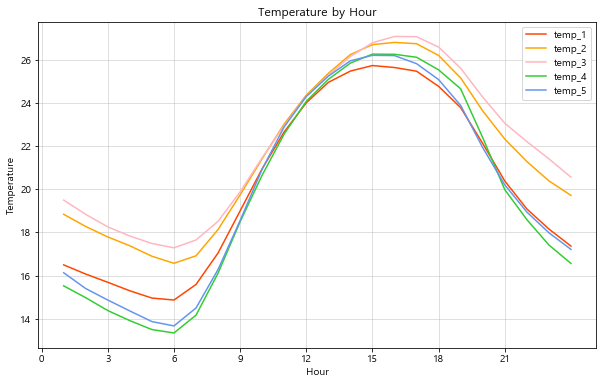

In [229]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

colors = ['orangered','orange','lightpink','limegreen','cornflowerblue']

# temp_hour와 hour를 그래프로 그려봄.
plt.plot(temp_hour.hour, temp_hour.평균온도_1, color = 'orangered', linestyle = 'solid')
plt.plot(temp_hour.hour, temp_hour.평균온도_2, color = 'orange', linestyle = 'solid')
plt.plot(temp_hour.hour, temp_hour.평균온도_3, color = 'lightpink', linestyle = 'solid')
plt.plot(temp_hour.hour, temp_hour.평균온도_4, color = 'limegreen',linestyle = 'solid')
plt.plot(temp_hour.hour, temp_hour.평균온도_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Hour')
plt.ylabel('Temperature')

major_ticks_x = np.arange(0, 24, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['temp_1','temp_2','temp_3','temp_4','temp_5',])

plt.title('Temperature by Hour')

plt.show()

## => 시간대별로 5곳의 온도는 차이는 있으나 전체적인 흐름은 유사함을 확인할 수 있다.

## d) 해면기압 & 지면기압


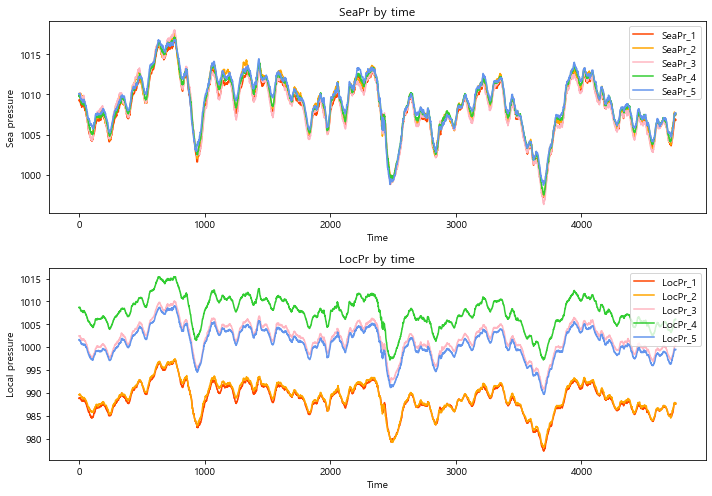

In [230]:
## 해면 기압
fig = plt.figure(figsize = (10,7))
plt.subplot(2,1,1)

# 해면기압 5개
plt.plot(train.id, train.SeaPr_1, color = 'orangered', linestyle = 'solid')
plt.plot(train.id, train.SeaPr_2, color = 'orange', linestyle = 'solid')
plt.plot(train.id, train.SeaPr_3, color = 'lightpink',linestyle = 'solid')
plt.plot(train.id, train.SeaPr_4, color = 'limegreen', linestyle = 'solid')
plt.plot(train.id, train.SeaPr_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Time')
plt.ylabel('Sea pressure')
plt.legend(['SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5',])
plt.title('SeaPr by time')
plt.subplot(2,1,2)

## 지면 기압
plt.plot(train.id, train.LocPr_1, color = 'orangered', linestyle = 'solid')
plt.plot(train.id, train.LocPr_2, color = 'orange', linestyle = 'solid')
plt.plot(train.id, train.LocPr_3, color = 'lightpink',linestyle = 'solid')
plt.plot(train.id, train.LocPr_4, color = 'limegreen', linestyle = 'solid')
plt.plot(train.id, train.LocPr_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Time')
plt.ylabel('Local pressure')

plt.legend(['LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5',])

plt.title('LocPr by time')

plt.tight_layout()
plt.show()

## ==> 해면기압과 지면기압은 유사한 흐름을 보이며, 순간의 변화는 적은 편이다. 역시 전반적인 흐름은 유사하다. 따라서 온도에 직접적인 영향을 끼친다고 판단하기에는 무리가 있다.

## e) 풍속

Text(0.5, 0, 'Time')

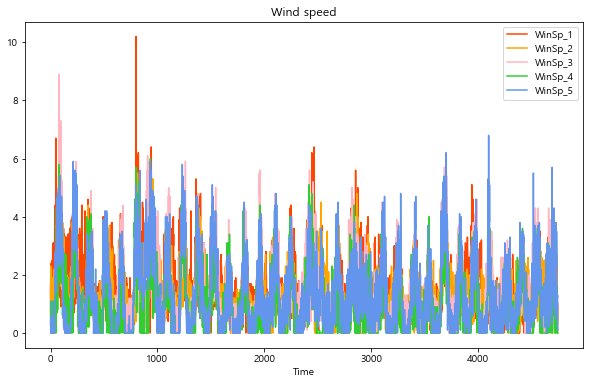

In [231]:
plt.figure(figsize=(10,6))
for i in range(len(Windspeed)):
    plt.plot(train[Windspeed[i]],color=colors[i], label=Windspeed[i])
    plt.legend()
plt.title('Wind speed')
plt.xlabel('Time')

## ==> 풍속은 날씨에 따라 온도와 유의미한 관계가 발생하기도, 발생하지도 않는다. 이를 일반화하여, 변수로 활용하기에는 어려움이 있음을 확인하였다.

## f) 일별 강수량 흐름

In [232]:
# 일별 강수량 흐름
a = train.groupby('day')['Rain_1'].agg([('Rain_day_1', 'mean')]).reset_index()
b = train.groupby('day')['Rain_2'].agg([('Rain_day_2', 'mean')]).reset_index()
c = train.groupby('day')['Rain_3'].agg([('Rain_day_3', 'mean')]).reset_index()
d = train.groupby('day')['Rain_4'].agg([('Rain_day_4', 'mean')]).reset_index()
e = train.groupby('day')['Rain_5'].agg([('Rain_day_5', 'mean')]).reset_index()
a

,day,Rain_day_1
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.000000
5,6,0.000000
6,7,9.674306
7,8,0.000000
8,9,0.000000
9,10,0.001389


In [233]:
# 일병 강수량 흐름 파악
# day 33개 별로 groupby 및 값 merge
rain_day = pd.merge(a,b, left_on = 'day', right_on = 'day', how = 'left')
rain_day = pd.merge(rain_day,c, left_on = 'day', right_on = 'day', how = 'left')
rain_day = pd.merge(rain_day,d, left_on = 'day', right_on = 'day', how = 'left')
rain_day = pd.merge(rain_day,e, left_on = 'day', right_on = 'day', how = 'left')
rain_day

,day,Rain_day_1,Rain_day_2,Rain_day_3,Rain_day_4,Rain_day_5
0,1,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,0.000000,0.000000,0.000000,0.000000,0.000000
6,7,9.674306,12.868056,12.187500,9.392361,20.305556
7,8,0.000000,0.000000,0.000000,0.000000,0.000000
8,9,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,0.001389,0.000000,0.000000,0.001389,0.006944


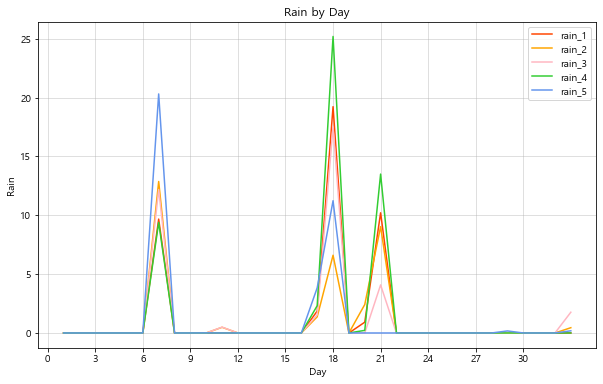

In [234]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

colors = ['orangered','orange','lightpink','limegreen','cornflowerblue']

plt.plot(rain_day.day, rain_day.Rain_day_1, color = 'orangered', linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_2, color = 'orange', linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_3, color = 'lightpink', linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_4, color = 'limegreen',linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Rain')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['rain_1','rain_2','rain_3','rain_4','rain_5',])

plt.title('Rain by Day')

plt.show()

## ==>강수여부는 온도와 유의미한 상관관계를 갖는 것으로 보인다. 뒤에서 온도와 비의 관계를 확인한다.

## g) 일사량

Text(0.5, 1.0, 'Insolation Boxplot')

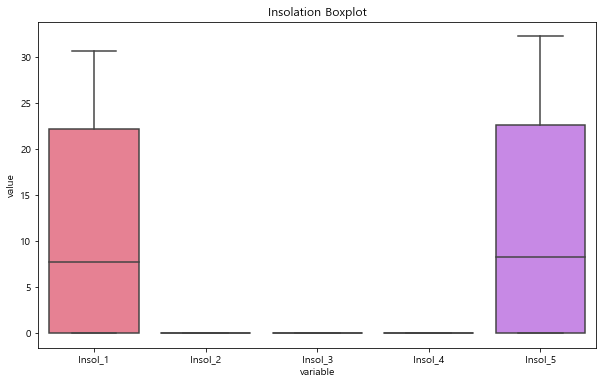

In [235]:
# g-1) 일사량 Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='variable', y='value', data = pd.melt(train[Insolation]),palette='husl')
plt.title('Insolation Boxplot')

## => Insolation 2 - 4 피쳐는 모든 데이터가 '0'이므로 삭제한다


In [236]:
X_data = X_data.drop(['Insol_2','Insol_3','Insol_4'], axis=1)
train = train.drop(['Insol_2','Insol_3','Insol_4'], axis=1)
test = test.drop(['Insol_2','Insol_3','Insol_4'], axis=1)
Insolation = ['Insol_1','Insol_5']

## g-2) 일별 일사량 흐름

In [237]:
a = train.groupby('day')['Insol_1'].agg([('Insol_day_1', 'mean')]).reset_index()
b = train.groupby('day')['Insol_5'].agg([('Insol_day_5', 'mean')]).reset_index()

Insol_day = pd.merge(a,b, left_on = 'day', right_on = 'day', how = 'left')
Insol_day

,day,Insol_day_1,Insol_day_5
0,1,14.645972,15.414306
1,2,14.352708,15.283056
2,3,14.024792,14.789861
3,4,13.571250,13.844722
4,5,10.989722,11.522639
5,6,13.664444,14.392431
6,7,1.578264,1.991042
7,8,11.455000,10.792778
8,9,14.329444,14.989792
9,10,10.062153,11.453681


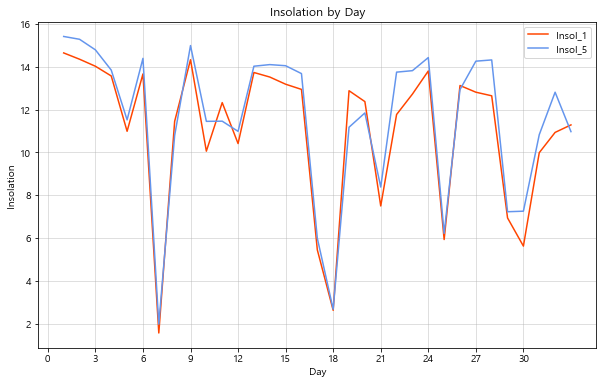

In [238]:
# 일별 일사량 흐름 시각화
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

plt.plot(Insol_day.day, Insol_day.Insol_day_1, color = 'orangered', linestyle = 'solid')
plt.plot(Insol_day.day, Insol_day.Insol_day_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Insolation')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['Insol_1', 'Insol_5'])

plt.title('Insolation by Day')

plt.show()

## => 일사량 역시 온도와 높은 상관관계를 보인다. 아래에서 종합적으로 확인할 예정이다.

## h) 일별 습도 흐름

In [239]:
# day 33일 별 습도 평균
a = train.groupby('day')['Humid_1'].agg([('Humid_day_1', 'mean')]).reset_index()
b = train.groupby('day')['Humid_2'].agg([('Humid_day_2', 'mean')]).reset_index()
c = train.groupby('day')['Humid_3'].agg([('Humid_day_3', 'mean')]).reset_index()
d = train.groupby('day')['Humid_4'].agg([('Humid_day_4', 'mean')]).reset_index()
e = train.groupby('day')['Humid_5'].agg([('Humid_day_5', 'mean')]).reset_index()

Humid_day = pd.merge(a,b, left_on = 'day', right_on = 'day', how = 'left')
Humid_day = pd.merge(Humid_day,c, left_on = 'day', right_on = 'day', how = 'left')
Humid_day = pd.merge(Humid_day,d, left_on = 'day', right_on = 'day', how = 'left')
Humid_day = pd.merge(Humid_day,e, left_on = 'day', right_on = 'day', how = 'left')
Humid_day

,day,Humid_day_1,Humid_day_2,Humid_day_3,Humid_day_4,Humid_day_5
0,1,59.593750,64.445833,51.895139,56.780556,50.175694
1,2,55.717361,60.722917,46.583333,49.090972,43.572917
2,3,59.653472,61.138889,50.970139,50.987500,43.736111
3,4,63.956944,67.535417,57.389583,57.843750,48.926389
4,5,56.870139,66.766667,54.611111,50.191667,44.447222
5,6,50.532639,56.212500,47.234028,46.695833,38.775694
6,7,86.090972,94.122917,84.029861,90.148611,80.265278
7,8,63.733333,62.340972,64.250000,64.323611,46.704861
8,9,58.625000,64.569444,59.047917,53.457639,41.911111
9,10,56.002083,64.768056,54.267361,54.421528,48.493750


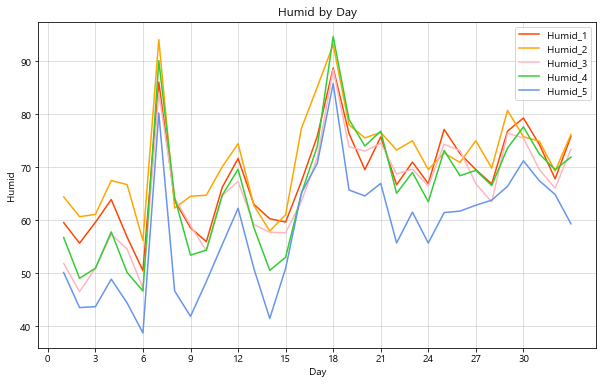

In [240]:
# 일별 습도 흐름 시각화
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

plt.plot(Humid_day.day, Humid_day.Humid_day_1, color = 'orangered', linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_2, color = 'orange', linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_3, color = 'lightpink', linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_4, color = 'limegreen',linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Humid')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['Humid_1','Humid_2','Humid_3','Humid_4','Humid_5',])

plt.title('Humid by Day')

plt.show()

## => 습도는 비와 높은 상관관계를 보인다.
## i) 풍향
- 풍향은 주어진 데이터로서의 의미보다는 **방향으로서의 의미가 중요하다고 판단하여, 본 분석에서는 45도씩 방향을 구분하여 원핫인코딩을 진행**하였다.

Text(0.5, 0, 'Time')

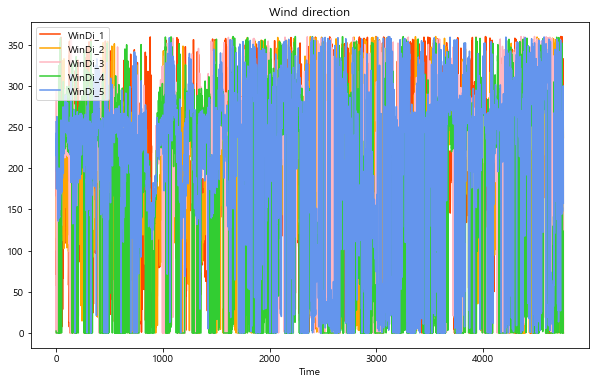

In [241]:
plt.figure(figsize=(10,6))
for i in range(len(Winddirection)):
    plt.plot(train[Winddirection[i]], color=colors[i], label=Winddirection[i])
    plt.legend()
plt.title('Wind direction')
plt.xlabel('Time')

## j) 온도와 일사량 비교

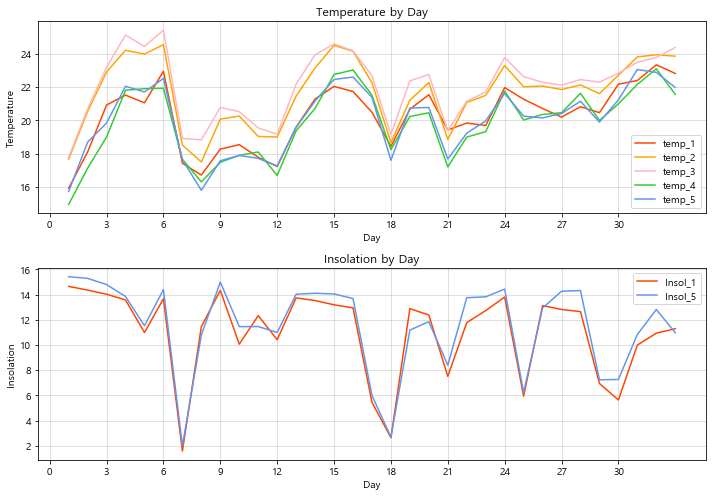

In [242]:
## 일별 온도량
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(2,1,1)

plt.plot(temp_day.day, temp_day.평균온도_1, color = 'orangered', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_2, color = 'orange', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_3, color = 'lightpink', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_4, color = 'limegreen',linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Temperature')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['temp_1','temp_2','temp_3','temp_4','temp_5',])
plt.title('Temperature by Day')


## 일별 일사량 비교
ax = fig.add_subplot(2,1,2)

plt.plot(Insol_day.day, Insol_day.Insol_day_1, color = 'orangered', linestyle = 'solid')
plt.plot(Insol_day.day, Insol_day.Insol_day_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Insolation')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['Insol_1', 'Insol_5'])

plt.title('Insolation by Day')

plt.tight_layout()
plt.show()

## =>온도가 낮은 날에는 일사량이 낮으며 온도가 높은 날에는 일사량이 높은 흐름을 확인할수 있다

## k) 온도, 비, 습도 비교

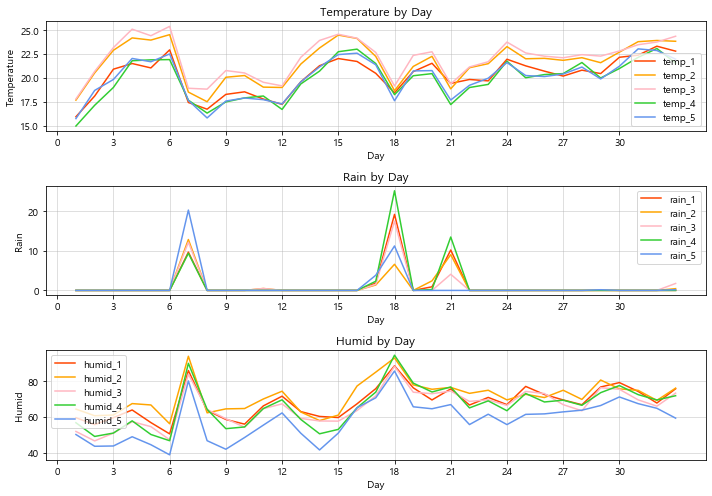

In [243]:
## 온도 비교
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(3,1,1)

plt.plot(temp_day.day, temp_day.평균온도_1, color = 'orangered', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_2, color = 'orange', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_3, color = 'lightpink', linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_4, color = 'limegreen',linestyle = 'solid')
plt.plot(temp_day.day, temp_day.평균온도_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Temperature')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['temp_1','temp_2','temp_3','temp_4','temp_5',])
plt.title('Temperature by Day')


## 비 비교
ax = fig.add_subplot(3,1,2)

plt.plot(rain_day.day, rain_day.Rain_day_1, color = 'orangered', linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_2, color = 'orange', linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_3, color = 'lightpink', linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_4, color = 'limegreen',linestyle = 'solid')
plt.plot(rain_day.day, rain_day.Rain_day_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Rain')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['rain_1','rain_2','rain_3','rain_4','rain_5',])
plt.title('Rain by Day')


## 습도 비교
ax = fig.add_subplot(3,1,3)

plt.plot(Humid_day.day, Humid_day.Humid_day_1, color = 'orangered', linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_2, color = 'orange', linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_3, color = 'lightpink', linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_4, color = 'limegreen',linestyle = 'solid')
plt.plot(Humid_day.day, Humid_day.Humid_day_5, color = 'cornflowerblue', linestyle = 'solid')

plt.xlabel('Day')
plt.ylabel('Humid')

major_ticks_x = np.arange(0, 33, 3)
ax.set_xticks(major_ticks_x)
ax.grid(which='major', alpha=0.5)

plt.legend(['humid_1','humid_2','humid_3','humid_4','humid_5',])

plt.title('Humid by Day')

plt.tight_layout()
plt.show()

## => 온도가 낮아지는 시점이 비가 온 시점과 일치함을 확인할 수 있으며, 비가 오는 시점에 습도 또한 높음을 확인할 수 있다.

# EDA 최종 종합
- 각 변수별 흐름을 시각화한 결과, **[일사량, 강수, 습도]는 온도와 높은 상관관계**를 확인할 수 있었다.
- 단, **습도와 강수는 역시 높은 관계**를 보인다.
- **일사량은 온도와 양의 상관관계**를 보이며, **강수와 습도는 온도와 음의 상관관계**를 보인다.
- 이를 바탕으로 Feature Engineering단계에서는 **'일사량', '강수', '습도', '온도' 변수를 적극적으로 활용**하며, 나머지 지표들은 응용하여 활용하는 방향을 설정하였다.

# 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling
- 머신러닝과 딥러닝에 사용한 변수가 다르기 때문에 X데이터를 두개로 나눠서 생성

## I. 머신러닝용 데이터
### 1) Time 변수

In [244]:
time = pd.DataFrame(X_data.id.apply(lambda x:x%144)) # 
time.columns = ['minute']
time['30min'] = time.minute.apply(lambda x:x//3 +1) # 3으로 나눴을 떄의 몫
time['hour'] = time.minute.apply(lambda x:x//6+1)
time['day'] = time.index // 144+1
time

## 시계열로 바꾸면서 데이터  시간을 맞춰논 듯?

,minute,30min,hour,day
0,0,1,1,1
1,1,1,1,1
2,2,1,1,1
3,3,2,1,1
4,4,2,1,1
...,...,...,...,...
16267,139,47,24,113
16268,140,47,24,113
16269,141,48,24,113
16270,142,48,24,113


In [245]:
# 최종 머신러닝용 데이터 만들기
X_data = pd.concat([X_data,time],axis=1)
print(X_data.shape)
X_data

(16272, 42)


,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,82.4,91.0,69.1,77.2,62.6,0,1,1,1
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,81.2,91.9,70.3,77.3,63.5,1,1,1,1
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,86.1,93.3,71.5,77.3,63.9,2,1,1,1
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,87.7,93.4,73.2,77.5,64.5,3,2,1,1
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,88.9,94.1,74.3,78.0,65.0,4,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,65.6,101.6,176.7,169.8,169.6,0.0,0.0,0.0,0.0,0.5,17.1,19.56,88.1,77.3,76.6,79.7,67.5,139,47,24,113
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,51.9,84.8,187.8,138.9,175.9,0.0,0.0,0.0,0.0,0.5,17.1,19.56,75.5,78.1,76.7,79.6,67.9,140,47,24,113
16269,16269,25.6,26.2,27.5,24.9,24.3,993.2,993.7,1005.4,1011.4,1005.0,1011.9,1013.2,1012.7,1013.0,1012.9,3.8,2.5,2.9,2.3,4.8,29.0,104.5,184.8,146.7,204.7,0.0,0.0,0.0,0.0,0.5,17.1,19.56,77.5,78.9,77.1,79.2,68.3,141,48,24,113
16270,16270,25.5,26.1,27.3,25.3,24.2,993.2,993.7,1005.3,1011.4,1005.0,1011.8,1013.2,1012.6,1013.0,1012.9,2.4,2.8,3.4,1.7,3.5,30.0,103.0,187.8,146.5,174.2,0.0,0.0,0.0,0.0,0.5,17.1,19.56,74.1,79.7,77.3,80.1,68.8,142,48,24,113


## 2) Rain, Insolation 10분단위 변화량

In [246]:
# 10분단위 데이터라서
X_data_in_diff_y = X_data
X_data_in_diff_y['Insol_1_10min'] = X_data_in_diff_y['Insol_1'].diff()
X_data_in_diff_y['Insol_5_10min'] = X_data_in_diff_y['Insol_5'].diff()
X_data_in_diff_y

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day,Insol_1_10min,Insol_5_10min
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,82.4,91.0,69.1,77.2,62.6,0,1,1,1,NaN,NaN
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,81.2,91.9,70.3,77.3,63.5,1,1,1,1,0.0,0.0
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,86.1,93.3,71.5,77.3,63.9,2,1,1,1,0.0,0.0
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,87.7,93.4,73.2,77.5,64.5,3,2,1,1,0.0,0.0
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,88.9,94.1,74.3,78.0,65.0,4,2,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,65.6,101.6,176.7,169.8,169.6,0.0,0.0,0.0,0.0,0.5,17.1,19.56,88.1,77.3,76.6,79.7,67.5,139,47,24,113,0.0,0.0
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,51.9,84.8,187.8,138.9,175.9,0.0,0.0,0.0,0.0,0.5,17.1,19.56,75.5,78.1,76.7,79.6,67.9,140,47,24,113,0.0,0.0
16269,16269,25.6,26.2,27.5,24.9,24.3,993.2,993.7,1005.4,1011.4,1005.0,1011.9,1013.2,1012.7,1013.0,1012.9,3.8,2.5,2.9,2.3,4.8,29.0,104.5,184.8,146.7,204.7,0.0,0.0,0.0,0.0,0.5,17.1,19.56,77.5,78.9,77.1,79.2,68.3,141,48,24,113,0.0,0.0
16270,16270,25.5,26.1,27.3,25.3,24.2,993.2,993.7,1005.3,1011.4,1005.0,1011.8,1013.2,1012.6,1013.0,1012.9,2.4,2.8,3.4,1.7,3.5,30.0,103.0,187.8,146.5,174.2,0.0,0.0,0.0,0.0,0.5,17.1,19.56,74.1,79.7,77.3,80.1,68.8,142,48,24,113,0.0,0.0


In [247]:
# 10분단위 데이터
Insol_10min = ['Insol_1_10min','Insol_5_10min']
Rain_10min = ['Rain_1_10min','Rain_2_10min','Rain_3_10min','Rain_4_10min','Rain_5_10min']

for i in Insol_10min:
    X_data_in_diff_y.loc[X_data_in_diff_y.query('minute ==0').index,i] = 0
X_data_diff_y = X_data_in_diff_y

X_data_in_diff_y['Rain_1_10min'] = X_data_in_diff_y['Rain_1'].diff()
X_data_in_diff_y['Rain_2_10min'] = X_data_in_diff_y['Rain_2'].diff()
X_data_in_diff_y['Rain_3_10min'] = X_data_in_diff_y['Rain_3'].diff()
X_data_in_diff_y['Rain_4_10min'] = X_data_in_diff_y['Rain_4'].diff()
X_data_in_diff_y['Rain_5_10min'] = X_data_in_diff_y['Rain_5'].diff()
X_data_in_diff_y

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,82.4,91.0,69.1,77.2,62.6,0,1,1,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,81.2,91.9,70.3,77.3,63.5,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,86.1,93.3,71.5,77.3,63.9,2,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,87.7,93.4,73.2,77.5,64.5,3,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,88.9,94.1,74.3,78.0,65.0,4,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,65.6,101.6,176.7,169.8,169.6,0.0,0.0,0.0,0.0,0.5,17.1,19.56,88.1,77.3,76.6,79.7,67.5,139,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,51.9,84.8,187.8,138.9,175.9,0.0,0.0,0.0,0.0,0.5,17.1,19.56,75.5,78.1,76.7,79.6,67.9,140,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16269,16269,25.6,26.2,27.5,24.9,24.3,993.2,993.7,1005.4,1011.4,1005.0,1011.9,1013.2,1012.7,1013.0,1012.9,3.8,2.5,2.9,2.3,4.8,29.0,104.5,184.8,146.7,204.7,0.0,0.0,0.0,0.0,0.5,17.1,19.56,77.5,78.9,77.1,79.2,68.3,141,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16270,16270,25.5,26.1,27.3,25.3,24.2,993.2,993.7,1005.3,1011.4,1005.0,1011.8,1013.2,1012.6,1013.0,1012.9,2.4,2.8,3.4,1.7,3.5,30.0,103.0,187.8,146.5,174.2,0.0,0.0,0.0,0.0,0.5,17.1,19.56,74.1,79.7,77.3,80.1,68.8,142,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3) Rain, Insolation 30분단위 변화량

In [248]:
# 강수량 30분 단위 변화량
# rain_30min column 들
Rain_30min = ['Rain_1_30min','Rain_2_30min','Rain_3_30min','Rain_4_30min','Rain_5_30min']

# 빈 df 생성
rain_1_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])

# day 114 - Rain1 - diff() 30분
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_1'].agg('max').diff().fillna(0)/2) # 차분에 대해 기울기를 구했다고 함.
    # list 삽입
    rain_1_30min_day.loc[i,:] = p

    
# day 114 - Rain2 - diff() 30분
rain_2_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_2'].agg('max').diff().fillna(0)/2)
    rain_2_30min_day.loc[i,:] = p

# day 114 - Rain3 - diff() 30분
rain_3_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_3'].agg('max').diff().fillna(0)/2)
    rain_3_30min_day.loc[i,:] = p

# day 114 - Rain4 - diff() 30분
rain_4_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_4'].agg('max').diff().fillna(0)/2)
    rain_4_30min_day.loc[i,:] = p

# day 114 - Rain5 - diff() 30분
rain_5_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_5'].agg('max').diff().fillna(0)/2)
    rain_5_30min_day.loc[i,:] = p

# x
X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)

rain_30min_day = [rain_1_30min_day, rain_2_30min_day,rain_3_30min_day, 
                  rain_4_30min_day, rain_5_30min_day ]

# 강수량 30분 단위 series 만들기
for k in range(5):
    rain_list = []
    # day 113 
    for i in range(113):
        for j in range(48):
            rain_list.append(rain_30min_day[k].iloc[i,j])
            rain_list.append(rain_30min_day[k].iloc[i,j])
            rain_list.append(rain_30min_day[k].iloc[i,j])
    X_data_sample[Rain[k]] = pd.Series(rain_list)
    
# 강수량 30분 단위 df 만들기
X_data_sample = X_data_sample.drop(columns=['id'],axis=1)
X_data[Rain_30min] = X_data_sample

print(rain_1_30min_day.shape, rain_2_30min_day.shape, rain_3_30min_day.shape)
print(rain_4_30min_day.shape, rain_5_30min_day.shape)

print('강수량 30분 단위 추가 완료')

(113, 48) (113, 48) (113, 48)
(113, 48) (113, 48)
강수량 30분 단위 추가 완료


In [249]:
# 일조량 30분 단위 변화들
# insol_30min의 column
Insol_30min = ['Insol_1_30min','Insol_5_30min']

# day 114 - insol_1 - diff() 30분
insol_1_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Insol_1'].agg('max').diff().fillna(0)/2)
    insol_1_30min_day.loc[i,:] = p

# day 114 - insol_5 - diff() 30분
insol_5_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Insol_5'].agg('max').diff().fillna(0)/2)
    insol_5_30min_day.loc[i,:] = p

#    
X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)
# insol 들 합침
insol_30min_day = [insol_1_30min_day,insol_5_30min_day]

# 일조량 30분 단위 series 만들기
for k in range(2):
    insol = []
    for i in range(113):
        for j in range(48):
            insol.append(insol_30min_day[k].iloc[i,j])
            insol.append(insol_30min_day[k].iloc[i,j])
            insol.append(insol_30min_day[k].iloc[i,j])
    X_data_sample[Insolation[k]] = pd.Series(insol)


# 일조량 30분 단위 df 만들기
X_data_sample = X_data_sample.drop(columns=['id'],axis=1)
X_data[Insol_30min] = X_data_sample

for i in Rain_10min:
    X_data_diff_y.loc[X_data_diff_y.query('minute ==0').index,i] = 0

print('일조량 30분 단위 추가 완료')

일조량 30분 단위 추가 완료


## 4) Rain, Insolation 1시간 단위 변화량

In [250]:
# 1시간 단위 강수량 변화량
# Rainn과 Insolation 은 누적변수니까 , 계속 증가만하니까 한시간단위로 잘라진 것
# day 114 - rain_1 - diff() 1시간
rain_1_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_1'].agg('max').diff().fillna(0)/2)
    rain_1_hour_day.loc[i,:] = p

# day 114 - rain_2 - diff() 1시간
rain_2_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_2'].agg('max').diff().fillna(0)/2)
    rain_2_hour_day.loc[i,:] = p

# day 114 - rain_3 - diff() 1시간
rain_3_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_3'].agg('max').diff().fillna(0)/2)
    rain_3_hour_day.loc[i,:] = p

# day 114 - rain_4 - diff() 1시간
rain_4_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_4'].agg('max').diff().fillna(0)/2)
    rain_4_hour_day.loc[i,:] = p

# day 114 - rain_5 - diff() 1시간
rain_5_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_5'].agg('max').diff().fillna(0)/2)
    rain_5_hour_day.loc[i,:] = p

# rain 1시간 들
X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)
rain_hour_day = [rain_1_hour_day,rain_2_hour_day,rain_3_hour_day,rain_4_hour_day,rain_5_hour_day]

# 강수량 1시간 단위 series 만들기
for k in range(5):
    rain_list = []
    for i in range(113):
        for j in range(24):
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
    X_data_sample[Rain[k]] = pd.Series(rain_list)
X_data_sample1 = X_data_sample.drop(columns=['id'],axis=1)

# 강수량 1시간 단위 df 만들기
X_data[Rain] = X_data_sample1

print('강수량 1시간 단위 추가 완료')

강수량 1시간 단위 추가 완료


In [251]:
# 1시간 단위 일조량 변화량

# day 114 - inso_1 - diff() 1시간
insol_1_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Insol_1'].agg('max').diff().fillna(0)/2)
    insol_1_hour_day.loc[i,:] = p

# day 114 - inso_5 - diff() 1시간
insol_5_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Insol_5'].agg('max').diff().fillna(0)/2)
    insol_5_hour_day.loc[i,:] = p

# 일조량 1시간 
X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)
insol_hour_day = [insol_1_hour_day,insol_5_hour_day]

# 일조량 1시간 단위 series 만들기
for k in range(2):
    insol = []
    for i in range(113):
        for j in range(24):
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
    X_data_sample[Insolation[k]] = pd.Series(insol)

# 일조량 1시간 단위 df 만들기
X_data_sample2 = X_data_sample.drop(columns=['id'],axis=1)
X_data[Insolation] = X_data_sample2

print('일조량 1시간 단위 추가 완료')

일조량 1시간 단위 추가 완료


## 5) 각 X별 평균

In [252]:
X_data['Temp_mean'] = pd.Series(X_data[Temperature].mean(axis=1))
X_data['LocPr_mean'] = pd.Series(X_data[Localpressure].mean(axis=1))
X_data['SeaPr_mean'] = pd.Series(X_data[Seapressure].mean(axis=1))
X_data['WinSp_mean'] = pd.Series(X_data[Windspeed].mean(axis=1))
X_data['Rain_mean'] = pd.Series(X_data[Rain].mean(axis=1))
X_data['Insol_mean'] = pd.Series(X_data[Insolation].mean(axis=1))
X_data['Humid_mean'] = pd.Series(X_data[Humid].mean(axis=1))
X_data['Rain_10min_mean'] = pd.Series(X_data[Rain_10min].mean(axis=1))
X_data['Insol_10min_mean'] = pd.Series(X_data[Insol_10min].mean(axis=1))
X_data['Rain_30min_mean'] = pd.Series(X_data[Rain_30min].mean(axis=1))
X_data['Insol_30min_mean'] = pd.Series(X_data[Insol_30min].mean(axis=1))
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,4,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,998.24,1009.82,0.50,0.0,0.0,80.06,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,65.6,101.6,176.7,169.8,169.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.1,77.3,76.6,79.7,67.5,139,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.54,1001.72,1012.70,3.12,0.0,0.0,77.84,0.0,0.0,0.0,0.0
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,51.9,84.8,187.8,138.9,175.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.5,78.1,76.7,79.6,67.9,140,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.84,1001.70,1012.68,3.10,0.0,0.0,75.56,0.0,0.0,0.0,0.0
16269,16269,25.6,26.2,27.5,24.9,24.3,993.2,993.7,1005.4,1011.4,1005.0,1011.9,1013.2,1012.7,1013.0,1012.9,3.8,2.5,2.9,2.3,4.8,29.0,104.5,184.8,146.7,204.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.5,78.9,77.1,79.2,68.3,141,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.70,1001.74,1012.74,3.26,0.0,0.0,76.20,0.0,0.0,0.0,0.0
16270,16270,25.5,26.1,27.3,25.3,24.2,993.2,993.7,1005.3,1011.4,1005.0,1011.8,1013.2,1012.6,1013.0,1012.9,2.4,2.8,3.4,1.7,3.5,30.0,103.0,187.8,146.5,174.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.1,79.7,77.3,80.1,68.8,142,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.68,1001.72,1012.70,2.76,0.0,0.0,76.00,0.0,0.0,0.0,0.0


## 6) 풍향 one-hot 인코딩

In [253]:
for i in range(1,6):
    a = 'WinDi_' + str(i)
    X_data[a] = X_data[a].apply(lambda x:x//45)
X_data[['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5']] = X_data[['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5']].astype(str)
X_data = pd.get_dummies(X_data, columns=['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5'])
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,4,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,998.24,1009.82,0.50,0.0,0.0,80.06,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.1,77.3,76.6,79.7,67.5,139,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.54,1001.72,1012.70,3.12,0.0,0.0,77.84,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.5,78.1,76.7,79.6,67.9,140,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## 7) 이슬점
- 이슬점 수식 : 온도와 상대습도 이용
- dewpint = t - (100 - rh)/5
- 5개의 온도센서와 상대습도센서의 위치를 알 수 없으므로 온도와 상대습도의 평균을 이용
- 참고자료 - (https://en.wikipedia.org/wiki/Dew_point) 에서 Simple approximation 참고

In [254]:
def dew_points(t, rh):
    dp = t - (100-rh)/5
    return dp

X_data['Dewpoint'] = X_data.apply(lambda x: dew_points(x['Temp_mean'], x['Humid_mean']), axis=1)

## 8) 공기밀도
- 온도와 현지기압 사이의 상관관계
- 공기밀도 수식 : 온도와 현지기압을 이용

- 공기밀도 = 현지기압 100 / (287.05 ( 온도 + 273.15))

- hPa단위를 Pa단위로 변환하는 수식 : hPa * 100
- 참고자료 - (https://www.brisbanehotairballooning.com.au/calculate-air-density/) 에서 6번문단(starts with : Density = ) 참조

In [255]:
# 공기밀도
def density_air(t,lp):
    rou = lp/(287.05*(273.15+t))*100
    return rou

X_data['Air_density_mean'] = X_data.apply(lambda x: density_air(x['Temp_mean'], x['LocPr_mean']), axis=1)

## 9) 시간대별 구분

In [256]:
def tense(x):
    if 0 < 6:
        return 0 # 새벽
    elif 6 < 12:
        return 1 # 오전
    elif 12 < 18:
        return 2 # 오후
    elif 18 <= 24:
        return 3 # 밤
    
X_data['hour'] = X_data.apply(lambda x: tense(x['hour']), axis=1)
X_data[['hour']] = X_data[['hour']].astype(str)
X_data = pd.get_dummies(X_data, columns=['hour'])
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint,Air_density_mean,hour_0
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,4,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,998.24,1009.82,0.50,0.0,0.0,80.06,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.012,1.228177,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.1,77.3,76.6,79.7,67.5,139,47,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.54,1001.72,1012.70,3.12,0.0,0.0,77.84,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,21.108,1.168337,1
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,

## 10) 체감온도
- 체감온도 수식 : **온도와 풍속을 이용**

- 체감온도 = 35.74 + (0.6215 x 온도(화씨)) - (35.75 x (풍속(mph)^0.16)) + (0.4275 x 온도(화씨) x (풍속(mph)^0.16))

- 화씨온도 변환하는 수식 : (1.8 x celsius) + 32
- 분속을 mph로 변환하는 수식 : 2.23694 x speed(m/h)
- 참고자료 - (https://www.weather.gov/media/epz/wxcalc/windChill.pdf) 에서 Wind Speed Conversion(WindChill=) 참조

In [257]:
# 체감온도
def wc(t, s):
    #섭씨 -> 화씨
    f = 1.8*t+32
    
    # m/s -> mph
    s = 2.23694 * s
    
    fer_chill = 35.74 + (.6215*f)-(35.75*(s**0.16)) + (0.4275*f*(s**0.16)) 
    
    # 화씨 체감온도 -> 섭씨 체감온도
    cel_chill = (fer_chill - 32)/1.8
    
    return cel_chill

X_data['Windchill'] = X_data.apply(lambda x: wc(x['Temp_mean'], x['WinSp_mean']), axis=1)

## 11) SSI (Summer Simmer Index)
- 온도와 습도 사이의 상관관계
- SSI(Summer Simmer Index) 수식 : 온도와 습도 이용

- SSI = 1.98 x (온도(화씨) - (0.55 - 0.0055 x (상대습도)) x (온도(화씨) - 58)) - 56.83

- 화씨온도 변환하는 수식 : (1.8 x celsius) + 32
- 참고자료 - (https://ncalculators.com/meteorology/summer-simmer-index-calculator.htm) 에서 Formula for Summer Simmer Index 참조

In [258]:
# SSI 지표
def SSI(t, rh):
    f = 1.8*t+32
    ssi = 1.98*(f-(0.55-(0.0055*rh))*(f-58)) - 56.83
    if ssi < 70:
        return 0 # cool
    elif 70 < 77:
        return 1 # moderately cool
    elif 77 < 83:
        return 2 # comfortable
    elif 83 < 91:
        return 3 # moderately warm
    elif 91 < 100:
        return 4 # warm
    elif 100 < 112:
        return 5 # very warm
    elif 112 < 125:
        return 6 # extremely warm
    elif 125 < 150:
        return 7 # dangerously warm
    else:
        return 8 # ssi> life threatening
    
X_data['SSI'] = X_data.apply(lambda x: SSI(x['Temp_mean'], x['Humid_mean']), axis=1)

X_data[['SSI']] = X_data[['SSI']].astype(str)
X_data = pd.get_dummies(X_data, columns=['SSI'])
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint,Air_density_mean,hour_0,Windchill,SSI_0,SSI_1
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1,11.357511,1,0
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1,11.034314,1,0
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1,10.859799,1,0
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1,11.338012,1,0
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,4,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,998.24,1009.82,0.50,0.0,0.0,80.06,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.012,1.228177,1,11.211204,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.1,77.3,76.6,79.7,67.5,139,47,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.54,1001.72,1012.70,3.12,0.0,0.0,77.84,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,21.108,1.168337,1,2

## 12) 고도
- 고도 수식 : 현지기압, 해면기압 이용
- 고도 = 44,330 x {1-(현지기압 / 해면기압)^0.190295}
- 참고자료 - 고도에 따른 기압변화 에서 3. 고도에 따른 대기압 참고

In [259]:
# 고도
def altitude(lp, sp):
    al = 44330*(1-(lp/sp)**0.190295)
    return al

X_data['Altitude'] = X_data.apply(lambda x: altitude(x['LocPr_mean'], x['SeaPr_mean']), axis=1)

## 13) 관측소별 강수량 평균

In [260]:
X_data['Rain_all_m'] = (X_data.Rain_1 + X_data.Rain_2 + X_data.Rain_3 + X_data.Rain_4 + X_data.Rain_5) / 5 

## 14) 강수량의 유무

In [261]:
def rain(x):
    if x > 0:
        return 1
    else:
        return 0
    
X_data['Rain_OX'] = X_data.apply(lambda x: rain(x['Rain_all_m']),axis=1)

## 15) 평균 온도와 관측소별 온도의 편차

In [262]:
X_data['Temp_1_diff'] = X_data['Temp_mean'] - X_data['Temp_1']
X_data['Temp_2_diff'] = X_data['Temp_mean'] - X_data['Temp_2']
X_data['Temp_3_diff'] = X_data['Temp_mean'] - X_data['Temp_3']
X_data['Temp_4_diff'] = X_data['Temp_mean'] - X_data['Temp_4']
X_data['Temp_5_diff'] = X_data['Temp_mean'] - X_data['Temp_5']

## 16) 증기압
- 증기압 수식 : 이슬점 이용
- 증기압 = 6.11 x 10^(7.5 x 이슬점/(237.7 + 이슬점))
- 참고자료 - (https://www.aprweather.com/pages/calc.htm) 에서 vapor pressure from dew point 참고

In [263]:
# 증기압
def vapor_p(x):
    e = 6.11*10**(7.5*x/(237.7+x))
    return e

X_data['Vapor_pressure_mean'] = X_data.apply(lambda x: vapor_p(x['Dewpoint']), axis=1)

## 17) 혼합비
- 혼합비 수식 : 증기압과 현지기압 이용
- 혼합비 = 621.97 * (증기압 / (현지기압 - 증기압))
- 참고자료 - (https://www.weather.gov/media/epz/wxcalc/mixingRatio.pdf) 에서 Pressure Conversion 참고

In [264]:
# 혼합비
def mr(e, lp):
    w = 621.97*(e/(lp-e))
    return w

X_data['Mixing_ratio_mean'] = X_data.apply(lambda x: mr(x['Vapor_pressure_mean'], x['LocPr_mean']), axis=1)

## 시간기반 계산위한 임시적인 시간데이터 추가
### 데이터 혼동을 막기 위해 날짜 계산을 할 데이터프레임을 따로 만든 후, 나중에 병합할 예정

In [265]:
# 
Date_df = X_data
Date_df['date'] = pd.date_range("2020-06-01 00:00:00", "2020-09-21 23:50:00", freq = "10T") # data_range 로 범위 객체 만들기
Date_df = Date_df.set_index('date')
df_summary = pd.DataFrame()

## 18) 일자별 일교차
- temp1-5를 하루 단위로 자른 후, max - min으로 일교차를 만들어 적용

In [266]:
df_summary['change_temp1'] = Date_df['Temp_1'].resample('1D').max() - Date_df['Temp_1'].resample('1D').min()
df_summary['change_temp2'] = Date_df['Temp_2'].resample('1D').max() - Date_df['Temp_2'].resample('1D').min()
df_summary['change_temp3'] = Date_df['Temp_3'].resample('1D').max() - Date_df['Temp_3'].resample('1D').min()
df_summary['change_temp4'] = Date_df['Temp_4'].resample('1D').max() - Date_df['Temp_4'].resample('1D').min()
df_summary['change_temp5'] = Date_df['Temp_5'].resample('1D').max() - Date_df['Temp_5'].resample('1D').min()

## 19) 일자별 평균온도
- temp 1-5를 하루 단위로 묶어 temp 1-5에 대한 평균온도 적용

In [267]:
df_summary['mean_temp1_day'] = Date_df['Temp_1'].resample('1D').mean()
df_summary['mean_temp2_day'] = Date_df['Temp_2'].resample('1D').mean()
df_summary['mean_temp3_day'] = Date_df['Temp_3'].resample('1D').mean()
df_summary['mean_temp4_day'] = Date_df['Temp_4'].resample('1D').mean()
df_summary['mean_temp5_day'] = Date_df['Temp_5'].resample('1D').mean()
df_summary

,change_temp1,change_temp2,change_temp3,change_temp4,change_temp5,mean_temp1_day,mean_temp2_day,mean_temp3_day,mean_temp4_day,mean_temp5_day
date,,,,,,,,,,
2020-06-01,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972
2020-06-02,17.3,13.6,15.1,20.6,18.9,18.106944,20.536111,20.692361,17.138889,18.697917
2020-06-03,16.3,13.6,14.6,20.3,19.8,20.927083,22.909722,23.191667,19.010417,19.846528
2020-06-04,17.1,16.7,16.0,22.3,22.3,21.520139,24.206250,25.123611,21.811806,22.053472
2020-06-05,13.8,11.7,11.3,16.3,16.6,21.058333,23.980556,24.436806,21.906944,21.707639
...,...,...,...,...,...,...,...,...,...,...
2020-09-17,6.5,5.0,6.7,6.6,6.7,24.643056,25.416667,26.402778,24.793056,24.443750
2020-09-18,6.0,5.8,8.2,8.2,7.1,25.687500,26.284028,27.595139,26.081944,25.268750
2020-09-19,7.0,5.6,5.6,9.2,8.4,24.131944,25.326389,25.475000,24.363194,23.877778


In [268]:
# 아래 과정을 통해 원래 데이터에 병합
Date_df_X = pd.DataFrame()

# 일자별 일교차
Date_df_X['change_temp1'] = df_summary.change_temp1.repeat(144)
Date_df_X['change_temp2'] = df_summary.change_temp2.repeat(144)
Date_df_X['change_temp3'] = df_summary.change_temp3.repeat(144)
Date_df_X['change_temp4'] = df_summary.change_temp4.repeat(144)
Date_df_X['change_temp5'] = df_summary.change_temp5.repeat(144)

# 일자별 평균온도
Date_df_X['mean_temp1_day'] = df_summary.mean_temp1_day.repeat(144)
Date_df_X['mean_temp2_day'] = df_summary.mean_temp2_day.repeat(144)
Date_df_X['mean_temp3_day'] = df_summary.mean_temp3_day.repeat(144)
Date_df_X['mean_temp4_day'] = df_summary.mean_temp4_day.repeat(144)
Date_df_X['mean_temp5_day'] = df_summary.mean_temp5_day.repeat(144)

Date_df_x = Date_df_X.reset_index()
Date_df_x = Date_df_x.drop(['date'], axis = 1)

# 일자별 일교차
X_data['change_temp1'] = Date_df_x.change_temp1
X_data['change_temp2'] = Date_df_x.change_temp2
X_data['change_temp3'] = Date_df_x.change_temp3
X_data['change_temp4'] = Date_df_x.change_temp4
X_data['change_temp5'] = Date_df_x.change_temp5

# 일자별 평균온도
X_data['mean_temp1_day'] = Date_df_x.mean_temp1_day
X_data['mean_temp2_day'] = Date_df_x.mean_temp2_day
X_data['mean_temp3_day'] = Date_df_x.mean_temp3_day
X_data['mean_temp4_day'] = Date_df_x.mean_temp4_day
X_data['mean_temp5_day'] = Date_df_x.mean_temp5_day

## 20) 관측소별 일평균 온도와 시간별 온도의 편차

In [269]:
X_data['diff_day_temp1'] = X_data['mean_temp1_day'] - X_data['Temp_1']
X_data['diff_day_temp2'] = X_data['mean_temp2_day'] - X_data['Temp_2']
X_data['diff_day_temp3'] = X_data['mean_temp3_day'] - X_data['Temp_3']
X_data['diff_day_temp4'] = X_data['mean_temp4_day'] - X_data['Temp_4']
X_data['diff_day_temp5'] = X_data['mean_temp5_day'] - X_data['Temp_5']
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint,Air_density_mean,hour_0,Windchill,SSI_0,SSI_1,Altitude,Rain_all_m,Rain_OX,Temp_1_diff,Temp_2_diff,Temp_3_diff,Temp_4_diff,Temp_5_diff,Vapor_pressure_mean,Mixing_ratio_mean,date,change_temp1,change_temp2,change_temp3,change_temp4,change_temp5,mean_temp1_day,mean_temp2_day,mean_temp3_day,mean_temp4_day,mean_temp5_day,diff_day_temp1,diff_day_temp2,diff_day_temp3,diff_day_temp4,diff_day_temp5
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1,11.357511,1,0,96.855166,0.0,0,0.92,-1.58,-1.68,2.42,-0.08,9.290775,5.843155,2020-06-01 00:00:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.238194,5.479861,5.501389,6.762500,5.040972
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1,11.034314,1,0,97.018019,0.0,0,1.12,-1.68,-1.68,2.12,0.12,9.211390,5.792528,2020-06-01 00:10:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.638194,5.579861,5.701389,6.662500,5.440972
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1,10.859799,1,0,97.186657,0.0,0,0.86,-1.84,-1.84,2.26,0.56,9.311359,5.856104,2020-06-01 00:20:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.538194,5.579861,5.701389,6.962500,6.040972
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1,11.338012,1,0,97.190525,0.0,0,0.72,-1.88,-1.98,2.42,0.72,9.329403,5.867797,2020-06-01 00:30:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.538194,5.679861,5.701389,7.262500,6.340972
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,

## 21) 일교차 평균
- X_data['Temp_mean']과 동일해 제거

In [270]:
# X_data['change_temp_mean'] = (X_data['change_temp1']+X_data['change_temp2']+ X_data['change_temp3']+X_data['change_temp4']+X_data['change_temp5']) / 5

## 22) 평균온도와 평균일사량의 편차

In [271]:
X_data['diff_Temp_ins_mean'] = X_data['Temp_mean'] - X_data['Insol_mean']

## 23) 평균일사량과 평균강수량의 차이

In [272]:
X_data['rain_ins']=X_data.apply(lambda x: x['Insol_mean']-x['Rain_mean'],axis=1)


## 24) 평균 일사량과 관측소별 일사량의 편차

In [273]:
X_data['Ins_diff_1'] = X_data['Insol_mean'] - X_data['Insol_1']
X_data['Ins_diff_5'] = X_data['Insol_mean'] - X_data['Insol_5']

## 25) 온도와 현지기압의 관계 (Pred_Temp)
- 예측온도 수식 : 온도와 현지기압 이용

- 예측온도 = 온도 * (1000 / 현지기압)^(8.314/1.005)

- 참고자료 - 온도와 강수를 이용하여 일별 일사량을 추정하기 위한 심층 신경망 모델 개발 에서 2.2. 심층 신경망 구조 참고

In [274]:
X_data['Pred_Temp'] = X_data['Temp_mean']*(1000/X_data['LocPr_mean'])**(8.314/1.005)

## 26) 포화 수증기압
- 포화 수증기압 수식 : 평균온도 이용

- 포화 수증기압 = 6.11 e ** (17.27 평균온도 / 237.3 + 평균온도)

- e : 자연상수
- 참고자료 - (https://makerjeju.tistory.com/27) 에서 Vapor Pressure(단위 Pa) 참고

In [275]:
# 포화 수증기압
def es(t):
    return 6.11*np.exp(17.27*t/(t+273.16-35.86))

X_data['Vapor_pressure_over'] = X_data.apply(lambda x: es(x['Temp_mean']),axis=1)

## 27) 공기중 수증기량
- 공기중 수증기량 수식 : 증기압과 현지기압 이용
- 공기중 수증기량 = 0.622 x 증기압/(현지기압 - 0.378 x 증기압)
- 참고자료 - (https://sambumts.tistory.com/419) 에서 g) 공기중의 비습 계산식 참고

In [276]:
# 공기중 수증기량
def va(e,P):
    s = 0.622 * e / (P-e)
    return s

X_data['Vapor_amount'] = X_data.apply(lambda x: va(x['Vapor_pressure_mean'],x['LocPr_mean']),axis=1)

## 28) 포화 절대 습도
- 포화 절대 습도 수식 : 포화수증기량과 평균온도 이용
- 포화 절대 습도 = 804 x 포화수증기량/(표준1기압(=1013.25hPa) x (1+0.00366 x 평균온도))
- 참고자료 - (https://sambumts.tistory.com/419) 에서 h) 포화절대습도 계산식 참고

In [277]:
def ps(e,t):
    ps = 804*e/((1013.25*(1+0.00366*t)))
    return ps

X_data['Absolute_Humidity'] = X_data.apply(lambda x:ps(x['Vapor_pressure_over'],x['Temp_mean']),axis=1)
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint,Air_density_mean,hour_0,Windchill,SSI_0,SSI_1,Altitude,Rain_all_m,Rain_OX,Temp_1_diff,Temp_2_diff,Temp_3_diff,Temp_4_diff,Temp_5_diff,Vapor_pressure_mean,Mixing_ratio_mean,date,change_temp1,change_temp2,change_temp3,change_temp4,change_temp5,mean_temp1_day,mean_temp2_day,mean_temp3_day,mean_temp4_day,mean_temp5_day,diff_day_temp1,diff_day_temp2,diff_day_temp3,diff_day_temp4,diff_day_temp5,diff_Temp_ins_mean,rain_ins,Ins_diff_1,Ins_diff_5,Pred_Temp,Vapor_pressure_over,Vapor_amount,Absolute_Humidity
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1,11.357511,1,0,96.855166,0.0,0,0.92,-1.58,-1.68,2.42,-0.08,9.290775,5.843155,2020-06-01 00:00:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.238194,5.479861,5.501389,6.762500,5.040972,10.62,0.0,0.0,0.0,10.775895,12.803408,0.005843,9.779218
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1,11.034314,1,0,97.018019,0.0,0,1.12,-1.68,-1.68,2.12,0.12,9.211390,5.792528,2020-06-01 00:10:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.638194,5.579861,5.701389,6.662500,5.440972,10.42,0.0,0.0,0.0,10.569455,12.633670,0.005793,9.656377
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1,10.859799,1,0,97.186657,0.0,0,0.86,-1.84,-1.84,2.26,0.56,9.311359,5.856104,2020-06-01 00:20:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.538194,5.579861,5.701389,6.962500,6.040972,10.26,0.0,0.0,0.0,10.408885,12.499308,0.005856,9.559071
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1,11.338012,1,0,97.190525,0.0,0,

## date 관련, 중복열 삭제

In [278]:
X_data = X_data.drop(['date','mean_temp1_day','mean_temp2_day','mean_temp3_day',
                     'mean_temp4_day','mean_temp5_day','day','minute','30min'], axis = 1)
ml_X_data = X_data

## II. 딥러닝용 데이터
### Data Cleansing & Preprocessing
- 딥러닝용 데이터를 만들기 위해 다시 데이터를 새로 불러오고 데이터 전처리를 한다.

In [279]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
X_data = pd.concat([train, test], sort=False).iloc[:,:41].reset_index()
X_data = X_data.drop(columns=['index'],axis=1)

X_data.columns=['id','Temp_1','LocPr_1','WinSp_1','WinSp_2','Rain_1','SeaPr_1','LocPr_2','Temp_2','SeaPr_2','SeaPr_3','Rain_2','Insol_1','Humid_1','WinDi_1','Insol_2','WinDi_2','Insol_3','WinDi_3','WinSp_3','Insol_4','Humid_2','Rain_3','LocPr_3','SeaPr_4','WinSp_4','WinDi_4','WinSp_5','LocPr_4','Temp_3','LocPr_5','Humid_3','Temp_4','Temp_5','SeaPr_5','Insol_5','WinDi_5','Rain_4','Humid_4','Humid_5','Rain_5']
X_data = X_data[['id','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5',
   'LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5',
   'SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5',
   'WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5',
   'WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5',
   'Rain_1','Rain_2','Rain_3','Rain_4','Rain_5',
   'Insol_1','Insol_5',
  'Humid_1','Humid_2','Humid_3','Humid_4','Humid_5']]

test.columns = ['id','Temp_1','LocPr_1','WinSp_1','WinSp_2','Rain_1','SeaPr_1','LocPr_2','Temp_2','SeaPr_2','SeaPr_3','Rain_2','Insol_1','Humid_1','WinDi_1','Insol_2','WinDi_2','Insol_3','WinDi_3','WinSp_3','Insol_4','Humid_2','Rain_3','LocPr_3','SeaPr_4','WinSp_4','WinDi_4','WinSp_5','LocPr_4','Temp_3','LocPr_5','Humid_3','Temp_4','Temp_5','SeaPr_5','Insol_5','WinDi_5','Rain_4','Humid_4','Humid_5','Rain_5']
test = test.drop(columns=['Insol_2','Insol_3','Insol_4'])
test = test[['id','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5',
   'LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5',
   'SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5',
   'WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5',
   'WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5',
   'Rain_1','Rain_2','Rain_3','Rain_4','Rain_5',
   'Insol_1','Insol_5',
  'Humid_1','Humid_2','Humid_3','Humid_4','Humid_5']]


train.columns = ['id','Temp_1','LocPr_1','WinSp_1','WinSp_2','Rain_1','SeaPr_1','LocPr_2','Temp_2','SeaPr_2','SeaPr_3','Rain_2','Insol_1','Humid_1','WinDi_1','Insol_2','WinDi_2','Insol_3','WinDi_3','WinSp_3','Insol_4','Humid_2','Rain_3','LocPr_3','SeaPr_4','WinSp_4','WinDi_4','WinSp_5','LocPr_4','Temp_3','LocPr_5','Humid_3','Temp_4','Temp_5','SeaPr_5','Insol_5','WinDi_5','Rain_4','Humid_4','Humid_5','Rain_5','Y00','Y01','Y02',"Y03",'Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']
train = train.drop(columns=['Insol_2','Insol_3','Insol_4'])
train = train[['id','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5',
   'LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5',
   'SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5',
   'WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5',
   'WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5',
   'Rain_1','Rain_2','Rain_3','Rain_4','Rain_5',
   'Insol_1','Insol_5',
  'Humid_1','Humid_2','Humid_3','Humid_4','Humid_5',
  'Y00','Y01','Y02',"Y03",'Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']]

Temperature = ['Temp_1','Temp_2','Temp_3','Temp_4','Temp_5']
Localpressure = ['LocPr_1','LocPr_2','LocPr_3','LocPr_4','LocPr_5']
Windspeed = ['WinSp_1','WinSp_2','WinSp_3','WinSp_4','WinSp_5']
Rain = ['Rain_1','Rain_2','Rain_3','Rain_4','Rain_5']
Seapressure = ['SeaPr_1','SeaPr_2','SeaPr_3','SeaPr_4','SeaPr_5']
Insolation = ['Insol_1','Insol_5']
Humid = ['Humid_1','Humid_2','Humid_3','Humid_4','Humid_5']
Winddirection = ['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5']
Time = ['minute','hour','day']
Y_data =  ['Y00','Y01','Y02','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']

## 1) Time 변수

In [280]:
# time 변수
time = pd.DataFrame(X_data.id.apply(lambda x:x%144))
time.columns = ['minute']
time['30min'] = time.minute.apply(lambda x:x//3 +1)
time['hour'] = time.minute.apply(lambda x:x//6+1)
time['day'] = time.index//144+1
X_data = pd.concat([X_data,time],axis=1)
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,82.4,91.0,69.1,77.2,62.6,0,1,1,1
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,81.2,91.9,70.3,77.3,63.5,1,1,1,1
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,86.1,93.3,71.5,77.3,63.9,2,1,1,1
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,87.7,93.4,73.2,77.5,64.5,3,2,1,1
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,88.9,94.1,74.3,78.0,65.0,4,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,65.6,101.6,176.7,169.8,169.6,0.0,0.0,0.0,0.0,0.5,17.1,19.56,88.1,77.3,76.6,79.7,67.5,139,47,24,113
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,51.9,84.8,187.8,138.9,175.9,0.0,0.0,0.0,0.0,0.5,17.1,19.56,75.5,78.1,76.7,79.6,67.9,140,47,24,113
16269,16269,25.6,26.2,27.5,24.9,24.3,993.2,993.7,1005.4,1011.4,1005.0,1011.9,1013.2,1012.7,1013.0,1012.9,3.8,2.5,2.9,2.3,4.8,29.0,104.5,184.8,146.7,204.7,0.0,0.0,0.0,0.0,0.5,17.1,19.56,77.5,78.9,77.1,79.2,68.3,141,48,24,113
16270,16270,25.5,26.1,27.3,25.3,24.2,993.2,993.7,1005.3,1011.4,1005.0,1011.8,1013.2,1012.6,1013.0,1012.9,2.4,2.8,3.4,1.7,3.5,30.0,103.0,187.8,146.5,174.2,0.0,0.0,0.0,0.0,0.5,17.1,19.56,74.1,79.7,77.3,80.1,68.8,142,48,24,113


## 2) Rain, Insolation 10분단위 변화량

In [281]:
X_data_in_diff_y = X_data
X_data_in_diff_y['Insol_1_10min'] = X_data_in_diff_y['Insol_1'].diff()
X_data_in_diff_y['Insol_5_10min'] = X_data_in_diff_y['Insol_5'].diff()

X_data_in_diff_y

Insol_10min = ['Insol_1_10min','Insol_5_10min']
Rain_10min = ['Rain_1_10min','Rain_2_10min','Rain_3_10min','Rain_4_10min','Rain_5_10min']

for i in Insol_10min:
    X_data_in_diff_y.loc[X_data_in_diff_y.query('minute ==0').index,i] = 0
X_data_diff_y = X_data_in_diff_y

X_data_in_diff_y['Rain_1_10min'] = X_data_in_diff_y['Rain_1'].diff()
X_data_in_diff_y['Rain_2_10min'] = X_data_in_diff_y['Rain_2'].diff()
X_data_in_diff_y['Rain_3_10min'] = X_data_in_diff_y['Rain_3'].diff()
X_data_in_diff_y['Rain_4_10min'] = X_data_in_diff_y['Rain_4'].diff()
X_data_in_diff_y['Rain_5_10min'] = X_data_in_diff_y['Rain_5'].diff()

## 3) Rain, Insolation 30분단위 변화량

In [285]:
Insol_30min = ['Insol_1_30min','Insol_5_30min']
Rain_30min = ['Rain_1_30min','Rain_2_30min','Rain_3_30min','Rain_4_30min','Rain_5_30min']

rain_1_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_1'].agg('max').diff().fillna(0)/2)
    rain_1_30min_day.loc[i,:] = p

    
rain_2_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_2'].agg('max').diff().fillna(0)/2)
    rain_2_30min_day.loc[i,:] = p

    
rain_3_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_3'].agg('max').diff().fillna(0)/2)
    rain_3_30min_day.loc[i,:] = p

    
rain_4_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_4'].agg('max').diff().fillna(0)/2)
    rain_4_30min_day.loc[i,:] = p

    
rain_5_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Rain_5'].agg('max').diff().fillna(0)/2)
    rain_5_30min_day.loc[i,:] = p

    
X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)
rain_30min_day = [rain_1_30min_day,rain_2_30min_day,rain_3_30min_day,rain_4_30min_day,rain_5_30min_day]
print('aa')

aa


In [286]:
for k in range(5):
    rain_list = []
    for i in range(113):
        for j in range(48):
            rain_list.append(rain_30min_day[k].iloc[i,j])
            rain_list.append(rain_30min_day[k].iloc[i,j])
            rain_list.append(rain_30min_day[k].iloc[i,j])
    X_data_sample[Rain[k]] = pd.Series(rain_list)
X_data_sample = X_data_sample.drop(columns=['id'],axis=1)
X_data[Rain_30min] = X_data_sample

insol_1_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Insol_1'].agg('max').diff().fillna(0)/2)
    insol_1_30min_day.loc[i,:] = p
insol_1_30min_day.shape

insol_5_30min_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,49)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('30min')['Insol_5'].agg('max').diff().fillna(0)/2)
    insol_5_30min_day.loc[i,:] = p
insol_5_30min_day.shape

X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)
insol_30min_day = [insol_1_30min_day,insol_5_30min_day]

for k in range(2):
    insol = []
    for i in range(113):
        for j in range(48):
            insol.append(insol_30min_day[k].iloc[i,j])
            insol.append(insol_30min_day[k].iloc[i,j])
            insol.append(insol_30min_day[k].iloc[i,j])
    X_data_sample[Insolation[k]] = pd.Series(insol)



X_data_sample = X_data_sample.drop(columns=['id'],axis=1)
X_data[Insol_30min] = X_data_sample

for i in Rain_10min:
    X_data_diff_y.loc[X_data_diff_y.query('minute ==0').index,i] = 0


## 4) Rain, Insolation 1시간단위 변화량

In [287]:
rain_1_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_1'].agg('max').diff().fillna(0)/2)
    rain_1_hour_day.loc[i,:] = p
rain_1_hour_day.shape

rain_2_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_2'].agg('max').diff().fillna(0)/2)
    rain_2_hour_day.loc[i,:] = p
rain_2_hour_day.shape

rain_3_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_3'].agg('max').diff().fillna(0)/2)
    rain_3_hour_day.loc[i,:] = p
rain_3_hour_day.shape

rain_4_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_4'].agg('max').diff().fillna(0)/2)
    rain_4_hour_day.loc[i,:] = p
rain_4_hour_day.shape

rain_5_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Rain_5'].agg('max').diff().fillna(0)/2)
    rain_5_hour_day.loc[i,:] = p
rain_5_hour_day.shape

X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)
rain_hour_day = [rain_1_hour_day,rain_2_hour_day,rain_3_hour_day,rain_4_hour_day,rain_5_hour_day]


In [288]:

for k in range(5):
    rain_list = []
    for i in range(113):
        for j in range(24):
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
            rain_list.append(rain_hour_day[k].iloc[i,j])
    X_data_sample[Rain[k]] = pd.Series(rain_list)
X_data_sample = X_data_sample.drop(columns=['id'],axis=1)
X_data[Rain] = X_data_sample

insol_1_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Insol_1'].agg('max').diff().fillna(0)/2)
    insol_1_hour_day.loc[i,:] = p
insol_1_hour_day.shape

insol_5_hour_day = pd.DataFrame(index=range(1,114), columns=[list(map(lambda x:float(x) , range(1,25)))])
for i in range(1,114):
    p = list(X_data[X_data['day']==i].groupby('hour')['Insol_5'].agg('max').diff().fillna(0)/2)
    insol_5_hour_day.loc[i,:] = p
insol_5_hour_day.shape

X_data_sample = X_data['id'].reset_index().drop(columns=['index'],axis=1)
insol_hour_day = [insol_1_hour_day,insol_5_hour_day]


In [289]:

for k in range(2):
    insol = []
    for i in range(113):
        for j in range(24):
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
            insol.append(insol_hour_day[k].iloc[i,j])
    X_data_sample[Insolation[k]] = pd.Series(insol)
X_data_sample = X_data_sample.drop(columns=['id'],axis=1)
X_data[Insolation] = X_data_sample
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,4,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,65.6,101.6,176.7,169.8,169.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.1,77.3,76.6,79.7,67.5,139,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,51.9,84.8,187.8,138.9,175.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.5,78.1,76.7,79.6,67.9,140,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16269,16269,25.6,26.2,27.5,24.9,24.3,993.2,993.7,1005.4,1011.4,1005.0,1011.9,1013.2,1012.7,1013.0,1012.9,3.8,2.5,2.9,2.3,4.8,29.0,104.5,184.8,146.7,204.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.5,78.9,77.1,79.2,68.3,141,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16270,16270,25.5,26.1,27.3,25.3,24.2,993.2,993.7,1005.3,1011.4,1005.0,1011.8,1013.2,1012.6,1013.0,1012.9,2.4,2.8,3.4,1.7,3.5,30.0,103.0,187.8,146.5,174.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.1,79.7,77.3,80.1,68.8,142,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5) 각 X별 평균

In [290]:
X_data['Temp_mean'] = pd.Series(X_data[Temperature].mean(axis=1))
X_data['LocPr_mean'] = pd.Series(X_data[Localpressure].mean(axis=1))
X_data['SeaPr_mean'] = pd.Series(X_data[Seapressure].mean(axis=1))
X_data['WinSp_mean'] = pd.Series(X_data[Windspeed].mean(axis=1))
X_data['Rain_mean'] = pd.Series(X_data[Rain].mean(axis=1))
X_data['Insol_mean'] = pd.Series(X_data[Insolation].mean(axis=1))
X_data['Humid_mean'] = pd.Series(X_data[Humid].mean(axis=1))
X_data['Rain_10min_mean'] = pd.Series(X_data[Rain_10min].mean(axis=1))
X_data['Insol_10min_mean'] = pd.Series(X_data[Insol_10min].mean(axis=1))
X_data['Rain_30min_mean'] = pd.Series(X_data[Rain_30min].mean(axis=1))
X_data['Insol_30min_mean'] = pd.Series(X_data[Insol_30min].mean(axis=1))
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,WinDi_1,WinDi_2,WinDi_3,WinDi_4,WinDi_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,hour,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,4,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,998.24,1009.82,0.50,0.0,0.0,80.06,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,1012.6,1012.9,1013.0,3.9,3.8,1.8,1.6,4.5,65.6,101.6,176.7,169.8,169.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.1,77.3,76.6,79.7,67.5,139,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.54,1001.72,1012.70,3.12,0.0,0.0,77.84,0.0,0.0,0.0,0.0
16268,16268,25.6,26.3,27.6,25.3,24.4,993.2,993.8,1005.2,1011.4,1004.9,1011.7,1013.3,1012.6,1012.9,1012.9,3.0,3.0,2.9,1.9,4.7,51.9,84.8,187.8,138.9,175.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.5,78.1,76.7,79.6,67.9,140,47,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.84,1001.70,1012.68,3.10,0.0,0.0,75.56,0.0,0.0,0.0,0.0
16269,16269,25.6,26.2,27.5,24.9,24.3,993.2,993.7,1005.4,1011.4,1005.0,1011.9,1013.2,1012.7,1013.0,1012.9,3.8,2.5,2.9,2.3,4.8,29.0,104.5,184.8,146.7,204.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.5,78.9,77.1,79.2,68.3,141,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.70,1001.74,1012.74,3.26,0.0,0.0,76.20,0.0,0.0,0.0,0.0
16270,16270,25.5,26.1,27.3,25.3,24.2,993.2,993.7,1005.3,1011.4,1005.0,1011.8,1013.2,1012.6,1013.0,1012.9,2.4,2.8,3.4,1.7,3.5,30.0,103.0,187.8,146.5,174.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.1,79.7,77.3,80.1,68.8,142,48,24,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.68,1001.72,1012.70,2.76,0.0,0.0,76.00,0.0,0.0,0.0,0.0


## 6) 풍향 one-hot 인코딩

In [291]:
# one-hot 인코딩
for i in range(1,6):
    a = 'WinDi_' + str(i)
    X_data[a] = X_data[a].apply(lambda x:x//45)
X_data[['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5']] = X_data[['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5']].astype(str)
X_data = pd.get_dummies(X_data, columns=['WinDi_1','WinDi_2','WinDi_3','WinDi_4','WinDi_5'])
print('완료')

완료


## 7) Dew points (이슬점)

In [292]:
# 이슬점
def dew_points(t, rh):
    dp = t - (100-rh)/5
    return dp

X_data['Dewpoint_mean'] = X_data.apply(lambda x: dew_points(x['Temp_mean'], x['Humid_mean']), axis=1)

print('완료')

완료


## 8) 공기밀도
- 온도와 현지기압 사이의 상관관계

In [293]:
def density_air(t,lp):
    rou = lp/(287.05*(273.15+t))*100
    return rou

X_data['Air_density_mean'] = X_data.apply(lambda x: density_air(x['Temp_mean'], x['LocPr_mean']), axis=1)

print('완료')

완료


## 9) 시간대별 구분

In [294]:
def tense(x):
    if 0 < 6:
        return 0 # 새벽
    elif 6 < 12:
        return 1 # 오전
    elif 12 < 18:
        return 2 # 오후
    elif 18 <= 24:
        return 3 # 밤
X_data['hour'] = X_data.apply(lambda x: tense(x['hour']), axis=1)
X_data[['hour']] = X_data[['hour']].astype(str)
X_data = pd.get_dummies(X_data, columns=['hour'])
print('완료')

완료


## 10) Wind Chill (체감온도)

In [295]:
# Wind Chill(체감온도)

def wc(t, s):
    #섭씨 -> 화씨
    f = 1.8*t+32
    
    # m/s -> mph
    s = 2.23694 * s
    
    fer_chill = 35.74 + (.6215*f)-(35.75*(s**0.16)) + (0.4275*f*(s**0.16)) 
    
    # 화씨 체감온도 -> 섭씨 체감온도
    cel_chill = (fer_chill - 32)/1.8
    
    return cel_chill

X_data['Windchill'] = X_data.apply(lambda x: wc(x['Temp_mean'], x['WinSp_mean']), axis=1)

11) SSI (Summer Simmer Index)
- 온도와 습도 사이의 상관관계

In [296]:
# SSI(Summer Simmer Index) : effect of temp & humidity

def SSI(t, rh):
    f = 1.8*t+32
    ssi = 1.98*(f-(0.55-(0.0055*rh))*(f-58)) - 56.83
    if ssi < 70:
        return 0 # cool
    elif 70 < 77:
        return 1 # moderately cool
    elif 77 < 83:
        return 2 # comfortable
    elif 83 < 91:
        return 3 # moderately warm
    elif 91 < 100:
        return 4 # warm
    elif 100 < 112:
        return 5 # very warm
    elif 112 < 125:
        return 6 # extremely warm
    elif 125 < 150:
        return 7 # dangerously warm
    else:
        return 8 # ssi> life threatening

X_data['SSI'] = X_data.apply(lambda x: SSI(x['Temp_mean'], x['Humid_mean']), axis=1)

## 12) 고도

In [297]:
def altitude(lp, sp):
    al = 44330*(1-(lp/sp)**0.190295)
    return al

X_data['Altitude'] = X_data.apply(lambda x: altitude(x['LocPr_mean'], x['SeaPr_mean']), axis=1)

## 13) 관측소별 강수량 평균

In [298]:
X_data['Rain_all_m'] = (X_data.Rain_1 + X_data.Rain_2 + X_data.Rain_3 + X_data.Rain_4 + X_data.Rain_5) / 5 

## 14) 강수량의 유무

In [299]:
def rain(x):
    if x > 0:
        return 1
    else:
        return 0
    
X_data['Rain_OX'] = X_data.apply(lambda x: rain(x['Rain_all_m']),axis=1)

## 15) 평균온도와 관측소별 온도의 편차

In [300]:
X_data['Temp_1_diff'] = X_data['Temp_mean'] - X_data['Temp_1']
X_data['Temp_2_diff'] = X_data['Temp_mean'] - X_data['Temp_2']
X_data['Temp_3_diff'] = X_data['Temp_mean'] - X_data['Temp_3']
X_data['Temp_4_diff'] = X_data['Temp_mean'] - X_data['Temp_4']
X_data['Temp_5_diff'] = X_data['Temp_mean'] - X_data['Temp_5']
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint_mean,Air_density_mean,hour_0,Windchill,SSI,Altitude,Rain_all_m,Rain_OX,Temp_1_diff,Temp_2_diff,Temp_3_diff,Temp_4_diff,Temp_5_diff
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1,11.357511,0,96.855166,0.0,0,0.92,-1.58,-1.68,2.42,-0.08
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1,11.034314,0,97.018019,0.0,0,1.12,-1.68,-1.68,2.12,0.12
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1,10.859799,0,97.186657,0.0,0,0.86,-1.84,-1.84,2.26,0.56
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1,11.338012,0,97.190525,0.0,0,0.72,-1.88,-1.98,2.42,0.72
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,4,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,998.24,1009.82,0.50,0.0,0.0,80.06,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.012,1.228177,1,11.211204,0,97.188591,0.0,0,0.80,-2.00,-2.00,2.60,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,16267,25.7,26.3,27.7,23.6,24.4,993.2,993.8,1005.2,1011.5,1004.9,1011.7,1013.3,10

## 16) 증기압

In [301]:
# 증기압
def vapor_p(x):
    e = 6.11*10**(7.5*x/(237.7+x))
    return e

X_data['Vapor_pressure_m'] = X_data.apply(lambda x: vapor_p(x['Dewpoint_mean']), axis=1)

## 17) 혼합비

In [302]:
# 혼합비
def mr(e, lp):
    w = 621.97*(e/(lp-e))
    return w

X_data['Mixing_ratio_m'] = X_data.apply(lambda x: mr(x['Vapor_pressure_m'], x['LocPr_mean']), axis=1)

## 시간기반 계산위한 임시적인 시간데이터 추가
### 데이터 혼동을 막기 위해 날짜 계산을 할 데이터프레임을 따로 만든 후, 나중에 병합할 예정

In [304]:
Date_df = X_data.copy()
Date_df['date'] = pd.date_range("2020-06-01 00:00:00", "2020-09-21 23:50:00", freq = "10T")
Date_df = Date_df.set_index('date')
df_summary = pd.DataFrame()

## 18) 일자별 일교차

In [305]:
df_summary['change_temp1'] = Date_df['Temp_1'].resample('1D').max() - Date_df['Temp_1'].resample('1D').min()
df_summary['change_temp2'] = Date_df['Temp_2'].resample('1D').max() - Date_df['Temp_2'].resample('1D').min()
df_summary['change_temp3'] = Date_df['Temp_3'].resample('1D').max() - Date_df['Temp_3'].resample('1D').min()
df_summary['change_temp4'] = Date_df['Temp_4'].resample('1D').max() - Date_df['Temp_4'].resample('1D').min()
df_summary['change_temp5'] = Date_df['Temp_5'].resample('1D').max() - Date_df['Temp_5'].resample('1D').min()

## 19) 일자별 평균

In [306]:
df_summary['mean_temp1_day'] = Date_df['Temp_1'].resample('1D').mean()
df_summary['mean_temp2_day'] = Date_df['Temp_2'].resample('1D').mean()
df_summary['mean_temp3_day'] = Date_df['Temp_3'].resample('1D').mean()
df_summary['mean_temp4_day'] = Date_df['Temp_4'].resample('1D').mean()
df_summary['mean_temp5_day'] = Date_df['Temp_5'].resample('1D').mean()

Date_df_X = pd.DataFrame()


### 아래 과정을 통해 원래 데이터에 병합

In [307]:
Date_df_X['change_temp1'] = df_summary.change_temp1.repeat(144)
Date_df_X['change_temp2'] = df_summary.change_temp2.repeat(144)
Date_df_X['change_temp3'] = df_summary.change_temp3.repeat(144)
Date_df_X['change_temp4'] = df_summary.change_temp4.repeat(144)
Date_df_X['change_temp5'] = df_summary.change_temp5.repeat(144)

Date_df_X['mean_temp1_day'] = df_summary.mean_temp1_day.repeat(144)
Date_df_X['mean_temp2_day'] = df_summary.mean_temp2_day.repeat(144)
Date_df_X['mean_temp3_day'] = df_summary.mean_temp3_day.repeat(144)
Date_df_X['mean_temp4_day'] = df_summary.mean_temp4_day.repeat(144)
Date_df_X['mean_temp5_day'] = df_summary.mean_temp5_day.repeat(144)

Date_df_x = Date_df_X.reset_index()
Date_df_x = Date_df_x.drop(['date'], axis = 1)

X_data['change_temp1'] = Date_df_x.change_temp1
X_data['change_temp2'] = Date_df_x.change_temp2
X_data['change_temp3'] = Date_df_x.change_temp3
X_data['change_temp4'] = Date_df_x.change_temp4
X_data['change_temp5'] = Date_df_x.change_temp5

X_data['mean_temp1_day'] = Date_df_x.mean_temp1_day
X_data['mean_temp2_day'] = Date_df_x.mean_temp2_day
X_data['mean_temp3_day'] = Date_df_x.mean_temp3_day
X_data['mean_temp4_day'] = Date_df_x.mean_temp4_day
X_data['mean_temp5_day'] = Date_df_x.mean_temp5_day

## 20) 관측소별 일평균 온도와 시간별 온도의 편차

In [308]:
X_data['diff_day_temp1'] = abs(X_data['mean_temp1_day'] - X_data['Temp_1'])
X_data['diff_day_temp2'] = abs(X_data['mean_temp2_day'] - X_data['Temp_2'])
X_data['diff_day_temp3'] = abs(X_data['mean_temp3_day'] - X_data['Temp_3'])
X_data['diff_day_temp4'] = abs(X_data['mean_temp4_day'] - X_data['Temp_4'])
X_data['diff_day_temp5'] = abs(X_data['mean_temp5_day'] - X_data['Temp_5'])
X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,minute,30min,day,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint_mean,Air_density_mean,hour_0,Windchill,SSI,Altitude,Rain_all_m,Rain_OX,Temp_1_diff,Temp_2_diff,Temp_3_diff,Temp_4_diff,Temp_5_diff,Vapor_pressure_m,Mixing_ratio_m,date,change_temp1,change_temp2,change_temp3,change_temp4,change_temp5,mean_temp1_day,mean_temp2_day,mean_temp3_day,mean_temp4_day,mean_temp5_day,diff_day_temp1,diff_day_temp2,diff_day_temp3,diff_day_temp4,diff_day_temp5
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1,11.357511,0,96.855166,0.0,0,0.92,-1.58,-1.68,2.42,-0.08,9.290775,5.843155,2020-06-01 00:00:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.238194,5.479861,5.501389,6.762500,5.040972
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1,11.034314,0,97.018019,0.0,0,1.12,-1.68,-1.68,2.12,0.12,9.211390,5.792528,2020-06-01 00:10:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.638194,5.579861,5.701389,6.662500,5.440972
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1,10.859799,0,97.186657,0.0,0,0.86,-1.84,-1.84,2.26,0.56,9.311359,5.856104,2020-06-01 00:20:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.538194,5.579861,5.701389,6.962500,6.040972
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,3,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1,11.338012,0,97.190525,0.0,0,0.72,-1.88,-1.98,2.42,0.72,9.329403,5.867797,2020-06-01 00:30:00,16.0,13.1,15.0,18.8,18.0,15.938194,17.679861,17.801389,14.962500,15.740972,6.538194,5.679861,5.701389,7.262500,6.340972
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0

### date 관련, 중복열 삭제

In [309]:
X_data = X_data.drop(['date','mean_temp1_day','mean_temp2_day','mean_temp3_day',
                     'mean_temp4_day','mean_temp5_day','day','minute','30min'], axis = 1)
dl_X_data = X_data
dl_X_data

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint_mean,Air_density_mean,hour_0,Windchill,SSI,Altitude,Rain_all_m,Rain_OX,Temp_1_diff,Temp_2_diff,Temp_3_diff,Temp_4_diff,Temp_5_diff,Vapor_pressure_m,Mixing_ratio_m,change_temp1,change_temp2,change_temp3,change_temp4,change_temp5,diff_day_temp1,diff_day_temp2,diff_day_temp3,diff_day_temp4,diff_day_temp5
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1,11.357511,0,96.855166,0.0,0,0.92,-1.58,-1.68,2.42,-0.08,9.290775,5.843155,16.0,13.1,15.0,18.8,18.0,6.238194,5.479861,5.501389,6.762500,5.040972
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1,11.034314,0,97.018019,0.0,0,1.12,-1.68,-1.68,2.12,0.12,9.211390,5.792528,16.0,13.1,15.0,18.8,18.0,6.638194,5.579861,5.701389,6.662500,5.440972
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1,10.859799,0,97.186657,0.0,0,0.86,-1.84,-1.84,2.26,0.56,9.311359,5.856104,16.0,13.1,15.0,18.8,18.0,6.538194,5.579861,5.701389,6.962500,6.040972
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1,11.338012,0,97.190525,0.0,0,0.72,-1.88,-1.98,2.42,0.72,9.329403,5.867797,16.0,13.1,15.0,18.8,18.0,6.538194,5.679861,5.701389,7.262500,6.340972
4,4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,1009.2,1010.1,1010.0,1009.7,1010.1,0.8,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.9,94.1,74.3,78.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,998.24,1009.82,0.50,0.0,0.0,80.06,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.012,1.228177,1,11.211204,0,97.188591,0.0,0,0.80,-2.00,-2.00,2.60,0.60,9.355234,5.884078,16.0,13.1,15.0,18.8,18.0,6.738194,5.679861,5.801389,7.56250

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation
### A. ML

### Train Test 데이터셋 분리


In [316]:
Y_data =  ['Y00','Y01','Y02','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']

train_y = train[Y_data]
train_X = ml_X_data.iloc[:4752,:]
train_y = train[Y_data]
train = pd.concat([train_X,train_y],axis=1)
test = ml_X_data.iloc[4752:,:]
train_30 = train.iloc[:4320,:]
train_3 = train.iloc[4320:,:]

Text(0.5, 1, 'Correlation Heatmap')

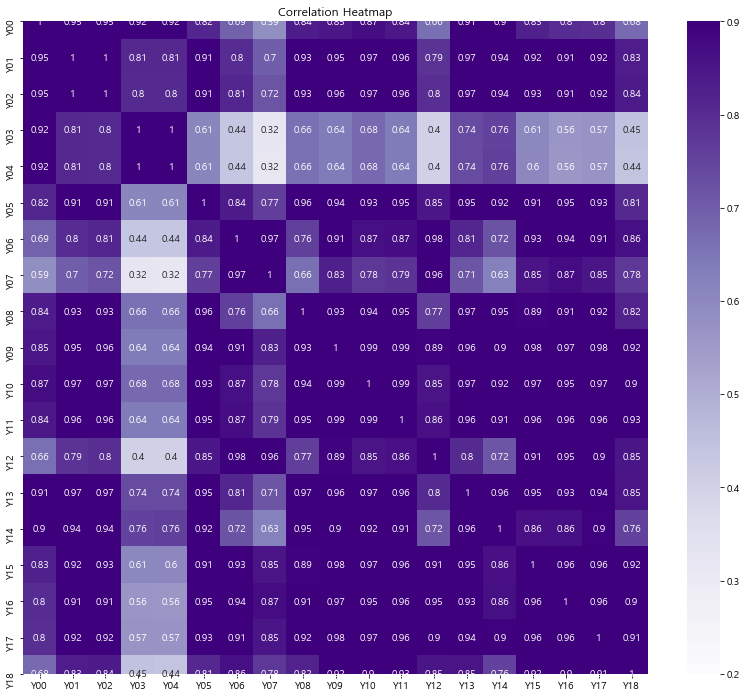

In [317]:
### Train의 Y18은 평균값으로 대치한다
correlations =  check_target.corr()
plt.figure(figsize = (14, 12))

# Heatmap of correlations
sns.heatmap(correlations, cmap = 'Purples',  vmin = 0.2, annot = True, vmax = 0.9)
plt.title('Correlation Heatmap')

### => 유의미한 관계가 보인다고 판단되는 상관계수가 0.83이상인 Y들로 30일 Y18을 채움

In [342]:
Y = ['Y05','Y06','Y09','Y10','Y11','Y12','Y13','Y15','Y16','Y17']
train_30['Y18'] = np.mean(train_30[Y], axis = 1)

train_30

,id,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,LocPr_1,LocPr_2,LocPr_3,LocPr_4,LocPr_5,SeaPr_1,SeaPr_2,SeaPr_3,SeaPr_4,SeaPr_5,WinSp_1,WinSp_2,WinSp_3,WinSp_4,WinSp_5,Rain_1,Rain_2,Rain_3,Rain_4,Rain_5,Insol_1,Insol_5,Humid_1,Humid_2,Humid_3,Humid_4,Humid_5,Insol_1_10min,Insol_5_10min,Rain_1_10min,Rain_2_10min,Rain_3_10min,Rain_4_10min,Rain_5_10min,Rain_1_30min,Rain_2_30min,Rain_3_30min,Rain_4_30min,Rain_5_30min,Insol_1_30min,Insol_5_30min,Temp_mean,LocPr_mean,SeaPr_mean,WinSp_mean,Rain_mean,Insol_mean,Humid_mean,Rain_10min_mean,Insol_10min_mean,Rain_30min_mean,Insol_30min_mean,WinDi_1_0.0,WinDi_1_1.0,WinDi_1_2.0,WinDi_1_3.0,WinDi_1_4.0,WinDi_1_5.0,WinDi_1_6.0,WinDi_1_7.0,WinDi_1_8.0,WinDi_2_0.0,WinDi_2_1.0,WinDi_2_2.0,WinDi_2_3.0,WinDi_2_4.0,WinDi_2_5.0,WinDi_2_6.0,WinDi_2_7.0,WinDi_3_0.0,WinDi_3_1.0,WinDi_3_2.0,WinDi_3_3.0,WinDi_3_4.0,WinDi_3_5.0,WinDi_3_6.0,WinDi_3_7.0,WinDi_3_8.0,WinDi_4_0.0,WinDi_4_1.0,WinDi_4_2.0,WinDi_4_3.0,WinDi_4_4.0,WinDi_4_5.0,WinDi_4_6.0,WinDi_4_7.0,WinDi_5_0.0,WinDi_5_1.0,WinDi_5_2.0,WinDi_5_3.0,WinDi_5_4.0,WinDi_5_5.0,WinDi_5_6.0,WinDi_5_7.0,Dewpoint,Air_density_mean,hour_0,Windchill,SSI_0,SSI_1,Altitude,Rain_all_m,Rain_OX,Temp_1_diff,Temp_2_diff,Temp_3_diff,Temp_4_diff,Temp_5_diff,Vapor_pressure_mean,Mixing_ratio_mean,change_temp1,change_temp2,change_temp3,change_temp4,change_temp5,diff_day_temp1,diff_day_temp2,diff_day_temp3,diff_day_temp4,diff_day_temp5,diff_Temp_ins_mean,rain_ins,Ins_diff_1,Ins_diff_5,Pred_Temp,Vapor_pressure_over,Vapor_amount,Absolute_Humidity,Y00,Y01,Y02,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,1009.3,1009.9,1009.8,1009.8,1010.1,1.2,0.6,0.3,1.1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.4,91.0,69.1,77.2,62.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.62,998.24,1009.78,0.74,0.0,0.0,76.46,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.912,1.225493,1,11.357511,1,0,96.855166,0.0,0,0.92,-1.58,-1.68,2.42,-0.08,9.290775,5.843155,16.0,13.1,15.0,18.8,18.0,6.238194,5.479861,5.501389,6.762500,5.040972,10.62,0.0,0.0,0.0,10.775895,12.803408,0.005843,9.779218,12.5,11.5,11.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,8.70
1,1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,1009.3,1010.0,1009.9,1009.9,1010.1,1.7,1.9,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,91.9,70.3,77.3,63.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.42,998.28,1009.84,0.80,0.0,0.0,76.84,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.788,1.226407,1,11.034314,1,0,97.018019,0.0,0,1.12,-1.68,-1.68,2.12,0.12,9.211390,5.792528,16.0,13.1,15.0,18.8,18.0,6.638194,5.579861,5.701389,6.662500,5.440972,10.42,0.0,0.0,0.0,10.569455,12.633670,0.005793,9.656377,12.5,11.0,11.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,8.45
2,2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,1009.2,1010.1,1010.1,1009.8,1010.0,1.1,2.3,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.1,93.3,71.5,77.3,63.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.26,998.26,1009.84,0.80,0.0,0.0,78.42,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.944,1.227075,1,10.859799,1,0,97.186657,0.0,0,0.86,-1.84,-1.84,2.26,0.56,9.311359,5.856104,16.0,13.1,15.0,18.8,18.0,6.538194,5.579861,5.701389,6.962500,6.040972,10.26,0.0,0.0,0.0,10.408885,12.499308,0.005856,9.559071,12.0,11.0,11.0,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,8.15
3,3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,1009.2,1010.0,1010.0,1009.7,1010.1,1.5,0.7,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.7,93.4,73.2,77.5,64.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.12,998.22,1009.80,0.50,0.0,0.0,79.26,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5.972,1.227632,1,11.338012,1,0,97.190525,0.0,0,0.72,-1.88,-1.98,2.42,0.72,9.329403,5

### => predict Y18 (평균으로 대치한 Y18)
train = pd.concat([train_30, train_3])

## GB (랜덤서치)
- 서브미션 제출 당시 gradient boosting 모델의 random state를 고정하지 않았고, 해당 모델 특성상 수많은 시도에도 불구 서브미션 제출 당시와 같은 값 산출이 불가하였습니다. 단, 어떠한 경우의수를 사용하더라도 최종 값이 크게 달라지지는 않았습니다. gradient boosting을 제외, 다른 부분에서는 달라진것이 전혀 없습니다. 이점 참고 부탁드립니다

In [349]:
%%time

X = train.iloc[:, 1:134] # 코드에는 142로 되있는데
y = train['Y18']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size = 0.3)
    
gb = GradientBoostingRegressor(learning_rate = 0.05141763076328964,max_depth= 16, 
        max_features =  'sqrt', min_samples_leaf = 12, 
        min_samples_split= 6, n_estimators =  288, random_state=77)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 학습

gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test.astype(np.int64))

print(metrics.r2_score(y_test,pred_gb))

mse = np.mean((pred_gb - y_test)**2)
print(mse)

pred_gb = gb.predict(test.iloc[:,1:134]) # 원래 142
pred_gb

(3326, 133) (3326,) (1426, 133) (1426,)
(3326, 133) (3326,) (1426, 133) (1426,)
0.6510771936399626
21.477381230822918
Wall time: 5.11 s


array([ 1.11158746e+01,  1.22855292e+01,  1.31353067e+01,  1.15118291e+01,
        1.10911994e+01,  1.18691385e+01,  1.15046898e+01,  1.19611723e+01,
        1.02879646e+01,  1.21471403e+01,  1.26110561e+01,  1.01080842e+01,
        9.69773780e+00,  8.18670110e+00,  8.17278950e+00,  8.76445591e+00,
        6.93503869e+00,  6.15163161e+00,  4.63237336e+00,  4.39163431e+00,
        4.36877779e+00,  5.23421350e+00,  4.29150080e+00,  4.33461087e+00,
        2.71485245e+00,  2.53512246e+00,  2.32470012e+00,  2.06320973e+00,
        2.17199661e+00,  2.11344758e+00,  2.09545507e+00,  2.55601662e+00,
        2.21884077e+00,  2.11438343e+00,  1.96153475e+00,  2.04121334e+00,
        2.11138237e+00,  2.69854332e+00,  1.85464014e+00,  2.10713986e+00,
        2.03028636e+00,  2.02914091e+00,  2.77563972e+00,  2.78068735e+00,
        2.19100450e+00,  2.04533229e+00,  2.11188864e+00,  1.70182890e+00,
        1.80183787e+00,  1.64305459e+00,  1.89289715e+00,  1.79246459e+00,
        2.11032087e+00,  

## XGB (랜덤서치)

In [358]:
%%time

X = train.iloc[:, 1:134] # 원래 코드 142
y = train['Y18']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, test_size = 0.3)
    
xgb = XGBRegressor(learning_rate = 0.04676877362294895, 
                   max_depth = 19, min_child_weight = 8, 
                   n_estimators = 215 )
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

xgb.fit(X_train, y_train)
     
pred_xgb = xgb.predict(X_test)
print(metrics.r2_score(y_test, pred_xgb))
    
mse = np.mean((pred_xgb - y_test)**2)
print(mse)

pred_xgb = xgb.predict(test.iloc[:,1:134]) # 원래 코드에는 142 
pred_xgb

(3326, 133) (3326,) (1426, 133) (1426,)
(3326, 133) (3326,) (1426, 133) (1426,)
0.9676580029946897
1.8963700995765882


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132'] ['Temp_1', 'Temp_2', 'Temp_3', 'Temp_4', 'Temp_5', 'LocPr_1', 'LocPr_2', 'LocPr_3', 'LocPr_4', 'LocPr_5', 'SeaPr_1', 'SeaPr_2', 'SeaPr_3', 'SeaPr_4', 'SeaPr_5', 'WinSp_1', 'WinSp_2', 'WinSp_3', 'WinSp_4', 'WinSp_5', 'Rain_1', 'Rain_2', 'Rain_3', 'Rain_4', 'Rain_5', 'Insol_1', 'Insol_5', 'Humid_1', 'Humid_2', 'Humid_3', 'Humid_4', 'Humid_5', 'Insol_1_10min', 'Insol_5_10min', 'Rain_1_10min', 'Rain_2_10min', 'Rain_3_10min', 'Rain_4_10min', 'Rain_5_10min', 'Rain_1_30min', 'Rain_2_30min', 'Rain_3_30min', 'Rain_4_30min', 'Rain_5_30min', 'Insol_1_30min', 'Insol_5_30min', 'Temp_mean', 'LocPr_mean', 'SeaPr_mean', 'WinSp_mean', 'Rain_mean', 'Insol_mean', 'Humid_mean', 'Rain_10min_mean', 'Insol_10min_mean', 'Rain_30min_mean', 'Insol_30min_mean', 'WinDi_1_0.0', 'WinDi_1_1.0', 'WinDi_1_2.0', 'WinDi_1_3.0', 'WinDi_1_4.0', 'WinDi_1_5.0', 'WinDi_1_6.0', 'WinDi_1_7.0', 'WinDi_1_8.0', 'WinDi_2_0.0', 'WinDi_2_1.0', 'WinDi_2_2.0', 'WinDi_2_3.0', 'WinDi_2_4.0', 'WinDi_2_5.0', 'WinDi_2_6.0', 'WinDi_2_7.0', 'WinDi_3_0.0', 'WinDi_3_1.0', 'WinDi_3_2.0', 'WinDi_3_3.0', 'WinDi_3_4.0', 'WinDi_3_5.0', 'WinDi_3_6.0', 'WinDi_3_7.0', 'WinDi_3_8.0', 'WinDi_4_0.0', 'WinDi_4_1.0', 'WinDi_4_2.0', 'WinDi_4_3.0', 'WinDi_4_4.0', 'WinDi_4_5.0', 'WinDi_4_6.0', 'WinDi_4_7.0', 'WinDi_5_0.0', 'WinDi_5_1.0', 'WinDi_5_2.0', 'WinDi_5_3.0', 'WinDi_5_4.0', 'WinDi_5_5.0', 'WinDi_5_6.0', 'WinDi_5_7.0', 'Dewpoint', 'Air_density_mean', 'hour_0', 'Windchill', 'SSI_0', 'SSI_1', 'Altitude', 'Rain_all_m', 'Rain_OX', 'Temp_1_diff', 'Temp_2_diff', 'Temp_3_diff', 'Temp_4_diff', 'Temp_5_diff', 'Vapor_pressure_mean', 'Mixing_ratio_mean', 'change_temp1', 'change_temp2', 'change_temp3', 'change_temp4', 'change_temp5', 'diff_day_temp1', 'diff_day_temp2', 'diff_day_temp3', 'diff_day_temp4', 'diff_day_temp5', 'diff_Temp_ins_mean', 'rain_ins', 'Ins_diff_1', 'Ins_diff_5', 'Pred_Temp', 'Vapor_pressure_over', 'Vapor_amount', 'Absolute_Humidity']
expected f26, f0, f12, f131, f86, f91, f13, f56, f39, f117, f50, f19, f60, f14, f21, f8, f9, f16, f36, f62, f10, f31, f37, f23, f42, f101, f69, f104, f17, f35, f73, f89, f102, f125, f64, f59, f78, f114, f6, f34, f127, f72, f108, f32, f66, f29, f48, f75, f105, f95, f4, f46, f122, f15, f99, f94, f40, f71, f84, f128, f57, f22, f124, f126, f77, f132, f5, f47, f1, f119, f76, f45, f68, f70, f116, f52, f123, f63, f112, f20, f87, f121, f58, f53, f74, f7, f115, f65, f111, f90, f97, f24, f79, f67, f92, f103, f2, f120, f3, f113, f44, f82, f93, f81, f33, f96, f38, f43, f129, f118, f61, f49, f51, f106, f28, f98, f109, f88, f27, f100, f41, f30, f130, f54, f85, f110, f107, f25, f83, f18, f55, f11, f80 in input data
training data did not have the following fields: WinSp_1, Dewpoint, Humid_2, WinDi_1_1.0, Rain_1_30min, Pred_Temp, WinDi_1_8.0, Rain_5_10min, WinDi_4_5.0, WinSp_mean, WinDi_5_2.0, Rain_3_30min, WinDi_5_7.0, Temp_1_diff, WinDi_2_1.0, WinDi_2_4.0, Temp_3_diff, WinDi_2_0.0, WinDi_3_0.0, Rain_10min_mean, SeaPr_mean, Rain_5, WinDi_1_5.0, Temp_2_diff, WinDi_5_1.0, WinDi_4_3.0, WinDi_5_6.0, LocPr_mean, WinDi_1_7.0, Ins_diff_5, Rain_4, LocPr_3, Rain_1_10min, diff_day_temp1, Humid_3, Windchill, Humid_1, Vapor_pressure_over, change_temp3, SeaPr_4, WinDi_3_6.0, change_temp5, Temp_2, rain_ins, hour_0, WinDi_1_4.0, Temp_4_diff, WinDi_2_7.0, diff_day_temp5, WinDi_1_3.0, WinDi_3_1.0, WinDi_4_7.0, Rain_4_10min, Humid_5, Insol_1_30min, Temp_mean, diff_day_temp3, WinDi_2_2.0, Rain_OX, Vapor_amount, WinDi_1_6.0, WinDi_2_3.0, Insol_5_30min, Temp_1, Humid_mean, WinDi_2_6.0, diff_Temp_ins_mean, SeaPr_3, Temp_3, Insol_1_10min, Rain_all_m, WinDi_5_3.0, Temp_5_diff, LocPr_5, WinDi_2_5.0, Rain_4_30min, Temp_4, Insol_30min_mean, SSI_0, WinDi_5_5.0, WinDi_5_0.0, WinDi_4_1.0, Absolute_Humidity, LocPr_2, Rain_30min_mean, WinSp_3, Altitude, change_temp4, Rain_2, WinDi_4_2.0, WinDi_4_0.0, change_temp2, WinDi_3_2.0, Vapor_pressure_mean, Temp_5, WinDi_3_5.0, Insol_5_10min, Mixing_ratio_mean, SSI_1, WinSp_2, Ins_diff_1, LocPr_1, SeaPr_5, Rain_3, LocPr_4, WinDi_3_8.0, Humid_4, SeaPr_1, Rain_2_30min, change_temp1, WinDi_3_3.0, WinSp_4, Rain_2_10min, Rain_3_10min, WinDi_1_0.0, WinDi_1_2.0, diff_day_temp4, Rain_mean, Rain_1, WinDi_5_4.0, Insol_5, WinDi_3_7.0, SeaPr_2, diff_day_temp2, Insol_10min_mean, WinSp_5, Rain_5_30min, Insol_mean, Insol_1, Air_density_mean, WinDi_4_6.0, WinDi_3_4.0, WinDi_4_4.0

## LGBM (랜덤서치)

In [354]:
%%time

X = train.iloc[:, 1:134]
y = train['Y18']
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=15, test_size = 0.3)
    
lgb = LGBMRegressor(subsample = 0.2, n_estimators = 200, min_child_weight = 0,
                    max_depth = 15, learniing_rate = 0.01, colsample_bytree = 0.2)

X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

lgb.fit(X_train,y_train)
    
pred_lgb = lgb.predict(X_test)
print(metrics.r2_score(y_test,pred_lgb))
    
mse = np.mean((pred_lgb - y_test)**2)
print(mse)
    
pred_lgb = lgb.predict(test.iloc[:,1:134])
pred_lgb

0.9884256085174404
0.7160734046846455
Wall time: 795 ms


array([ 1.63566355e+01,  1.64709496e+01,  1.76889290e+01,  1.65933819e+01,
        1.65143293e+01,  1.61547641e+01,  1.60081715e+01,  1.54560769e+01,
        1.44047711e+01,  1.45325811e+01,  1.38897806e+01,  1.21156686e+01,
        1.22901663e+01,  1.12743981e+01,  1.15391423e+01,  1.20588423e+01,
        1.31964211e+01,  1.22553894e+01,  8.50890206e+00,  7.84697047e+00,
        8.84586430e+00,  8.71165348e+00,  8.62250236e+00,  8.29955011e+00,
        5.70856405e+00,  5.52295402e+00,  4.49335051e+00,  2.95911046e+00,
        3.57592101e+00,  3.03643952e+00,  3.06981836e+00,  3.37865582e+00,
        3.03541621e+00,  3.21415388e+00,  2.05686308e+00,  2.33032332e+00,
        2.35977859e+00,  2.30640638e+00,  2.08848085e+00,  1.98440188e+00,
        2.18647932e+00,  2.32213513e+00,  3.26901016e+00,  3.08023500e+00,
        2.92868573e+00,  2.70649536e+00,  2.77445087e+00,  1.93729830e+00,
        2.04670454e+00,  2.14043622e+00,  2.26811229e+00,  2.16664105e+00,
        2.84890887e+00,  

## G-mean을 통한 기하평균

In [355]:
ens = gmean([pred_gb, pred_xgb, pred_lgb])

submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':ens.reshape(1,-1)[0]})
submit.to_csv('Ensemble/ml.csv', index = False)

# 기하평균 적용함. 

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method

## B) DL
- random 패키지의 seed를 고정하지 않아서 결과물이 다르게 나올 수 있어 저장한 모델을 첨부했으며 코드에 반영되어 있음

## Functions
- 코드 공유에 올라와 있는 euphoria님의 자료를 참고하였습니다.
- 출처 (https://dacon.io/competitions/official/235584/codeshare/738)

In [359]:
def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

def mse_keras(y_true, y_pred):
    score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') # tf 2.x
    #score = tf.py_func( lambda y_true, y_pred : mse_AIFrenz(y_true, y_pred) , [y_true, y_pred], 'float32', stateful = False, name = 'custom_mse' ) # tf 1.x
    return score

## Load Data & Preprocessing

In [360]:
train_D = dl_X_data.iloc[:4752,:]
test_D = dl_X_data.iloc[4752:,:]

train_o = pd.read_csv('data/train.csv')
test_o = pd.read_csv('data/test.csv')

train_pre = train_D.drop(['id'], axis = 1).iloc[:,:].copy()
test_pre = test_D.drop(['id'], axis = 1).iloc[:,:].copy()

train_pre = np.array(train_pre)
test_pre = np.array(test_pre)

In [361]:
train1 = train_pre[:4320,:].copy()

# 시계열 모형은 t시점의 데이터로 t+1 시점을 예측하기 때문에 한 시점씩 밀어서 사용
# pre_train model에 사용할 Y값 추출

y05 =  np.array(train_o.loc[:4319 ,'Y05'])[1:]
y06 =  np.array(train_o.loc[:4319 ,'Y06'])[1:]
y09 =  np.array(train_o.loc[:4319 ,'Y09'])[1:]
y10 =  np.array(train_o.loc[:4319 ,'Y10'])[1:]
y11 =  np.array(train_o.loc[:4319 ,'Y11'])[1:]
y12 =  np.array(train_o.loc[:4319 ,'Y12'])[1:]
y13 =  np.array(train_o.loc[:4319 ,'Y13'])[1:]
y15 =  np.array(train_o.loc[:4319 ,'Y15'])[1:]
y16 =  np.array(train_o.loc[:4319 ,'Y16'])[1:]
y17 =  np.array(train_o.loc[:4319 ,'Y17'])[1:]

# transfer learning에 사용할 Y값 추출

y18 =  np.array(train_o.loc[4320: ,'Y18'])[1:]

In [362]:
# 시계열 모형은 t시점의 데이터로 t+1 시점을 예측하기 때문에 한 시점씩 당겨서 사용
# 시계열 모델에 넣기 위해 X값을 3차원 tensor로 변환 (pre_train model 용)

X_train = train1[:-1,:]
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# 시계열 모델에 넣기 위해 X값을 3차원 tensor로 변환 (transfer learning 용)

train2 = train_pre[4320:,:].copy()
X_train2 = train2[:-1,:]
X_train2 = np.array(X_train2)
X_train2 = np.reshape(X_train2, (X_train2.shape[0], 1, X_train2.shape[1]))

# 시계열 모델에 넣기 위해 X값을 3차원 tensor로 변환 (예측 용)

X_test = test_pre
X_test = np.vstack((np.array(train2[-1,:]).reshape((1,127)), X_test[:-1,:]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

ValueError: cannot reshape array of size 124 into shape (1,127)

## Modeling
### Pre-trained Model


In [ ]:
### Pre-trained Model# keras functional API를 통해 모델을 구성 (multi-output model 구조)
# pre-trained layer는 regressor를 이후 부분을 떼고 앞의 GRU layer만 사용

input_x = Input(shape = (None, 127))
x = GRU(512, return_sequences = True, activation = ReLU())(input_x)
x = GRU(512, return_sequences = True, activation = ReLU())(x)
x = GRU(512, return_sequences = True, activation = ReLU())(x)
x = GRU(512, return_sequences = True, activation = ReLU())(x)
x = GRU(512, return_sequences = False, activation = ReLU())(x)

# 과적합 방지를 위해 Dropout 적용

x = Dropout(0.10)(x)

# Regressor

x = Dense(32, activation = ReLU())(x)
x = Dense(16, activation = ReLU())(x)

# output

out05 = Dense(1, name = 'y05')(x)
out06 = Dense(1, name = 'y06')(x)
out09 = Dense(1, name = 'y09')(x)
out10 = Dense(1, name = 'y10')(x)
out11 = Dense(1, name = 'y11')(x)
out12 = Dense(1, name = 'y12')(x)
out13 = Dense(1, name = 'y13')(x)
out15 = Dense(1, name = 'y15')(x)
out16 = Dense(1, name = 'y16')(x)
out17 = Dense(1, name = 'y17')(x)

# model 정의 

model = Model(input_x, [out05,
                        out06,
                        out09,
                        out10,
                        out11,
                        out12,
                        out13,
                        out15,
                        out16, 
                        out17])
model.summary()


In [ ]:
# model 구조 시각화
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=False, to_file ='pre.png')

In [ ]:
# metric으로 mse_AIFrenz 사용
model.compile(optimizer = Adam(), loss = ['mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse'], metrics=[mse_keras])

In [ ]:
# model 학습 
# epochs 원래는 150
model.fit(X_train, [y05, y06, y09, y10, y11, y12, y13, y15, y16, y17], epochs = 10, batch_size= 128)
model.save('models/pre_model_1.h5')
print('model 저장완료')

## Transfer Learning

In [ ]:
# pre-train model 불러오기
with CustomObjectScope({'ReLU' : ReLU(), 'mse_keras' : mse_keras}):
    model = load_model('models/pre_model.h5')

In [ ]:
# pre_train model의 layer를 불러옴

pre_layer1 = model.layers[1]
pre_layer2 = model.layers[2]
pre_layer3 = model.layers[3]
pre_layer4 = model.layers[4]
pre_layer5 = model.layers[5]

In [ ]:
# pre_train layer를 학습불가능하게 설정

pre_layer1.trainable = False
pre_layer2.trainable = False
pre_layer3.trainable = False
pre_layer4.trainable = False
pre_layer5.trainable = False

In [ ]:
# pre_train layer를 사용

input_x = Input(shape = (None, 127))
x = pre_layer1(input_x)
x = pre_layer2(x)
x = pre_layer3(x)
x = pre_layer4(x)
x = pre_layer5(x)

# 과적합 방지를 위해 Dropout 적용

x = Dropout(0.1)(x)

# regressor

x = Dense(64,
          activation=ReLU(), kernel_regularizer = regularizers.l2(0.1))(x)
x = Dense(32,
          activation=ReLU(), kernel_regularizer = regularizers.l2(0.1))(x)

# output

out18 = Dense(1, name = 'y18')(x)

# model 정의 

model2 = Model(input_x, out18)
model2.summary()


In [ ]:
# model 시각화
tf.keras.utils.plot_model(model2,show_shapes=True, show_layer_names=False, to_file ='reg.png')

In [ ]:
# metric으로 mse_AIFrenz 사용
model2.compile(optimizer = Adam(), loss = ['mse'], metrics=[mse_keras])

# model 학습
model2.fit(X_train2, y18, epochs = 150, batch_size = 16)

# 모델 저장
model2.save('models/class_model_1.h5')


In [ ]:
# transfer learning model 불러오기
with CustomObjectScope({'ReLU' : ReLU(), 'mse_keras' : mse_keras}):
    model2 = load_model('models/class_model.h5')

In [ ]:
# Submission 만들기
finetune_pred = model2.predict(X_test)
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':finetune_pred.reshape(1,-1)[0]})
submit.to_csv('Ensemble/dl.csv', index = False)
submit

In [ ]:
# 예측값 시각화
plt.figure(figsize = (18,6))
plt.plot(submit.Y18)
plt.show()

In [ ]:
# 예측값 최댓값, 최솟값
display(submit.Y18.min())
display(submit.Y18.max())

## Make Submission
- power mean

In [ ]:
folder = 'Ensemble'
nf = 0
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="id")
    nf += 1

p = 2.56   
if nf >= 2:
    pred = 0
    for j in  range(nf): pred = pred + slist.iloc[:,j+1]**p 
    pred = pred / nf    
    pred = pred**(1/p)

    submit = pd.DataFrame({'id': slist.id, 'Y18': pred})
    t = pd.Timestamp.now()
    fname = "Submission/submission_PM_" + str(t.month) + str(t.day) + "_" + str(t.hour) + str(t.minute) + ".csv"
    submit.to_csv(fname, index=False)

## 6. 결과 및 결언
## Conclusion & Discussion
### 1. 머신러닝과 딥러닝을 Scale하지 않고 학습을 진행
- 비와 관련된 변수가 tran_data에 비해 test_data에 매우 높은 값이 있기 때문에 scale을 사용하지 않았다.

### 2. 첫 30일치 Y18 데이터를 상관관계가 높은Y값들의 평균으로 대체
- 머신러닝에서 첫 30일 Y18 데이터값을 채우기 위해 모델링을 했지만, 전체적으로 불확실성이 높았다. 또한, 학습에 사용한 3일치 데이터의 온도가 높아 예측값이 일정 온도 이하로 내려가지 않는 현상이 발생하여 위의 방법을 사용하였다.

### 3. 딥러닝은 모델을 크게 만들고 drop-out이나 규제를 적용
- 위의 방법을 통해 과적합을 방지하고 보다 더 좋은 결과를 도출할 수 있었다.

### 4. 머신러닝과 딥러닝 모델을 앙상블
- 앙상블을 통해 머신러닝과 딥러닝 모델을 상호 보완했다.(Tree기반, Neural Net기반)